**Problem Formulation**

### **Define the problem:**
This is a binary classification Task.

It is a binary classification problem based on the graph data.

**The goal**  
is to use the molecular structure of a chemical substance to predict its anticancer activity. The chemical substance can be either positive or negative in terms of lung cancer cell resistance, and so is labelled as 0 or 1.

**What is the input?**

The data is presented in the form of a graph that depicts the compound's chemical structure. Each data sample includes information on the atoms in the molecule as well as the connections between them. The atoms and connections are the inputs features of this problem.



**What is the output?**

the output is the prediction of the anticancer activity of a chemical compound using the chemical structure of the compound. The chemical compound can be positive or negative [0, 1]

**What data mining function is required?**

**Import libraries**

which used in the models and to help me to deal with many things like preprocessing and build the models and so on.


**Load the data**

to deal with the model to make a prediction


**Virtualize the data**

to help me to find any information or pattern


**Data preprocessing**

Characters such as ['O','N','S',....] are used to represent nodes (atoms). As a result, it's viewed as a sequence of text data, with the best method to characterise it being to tokenize the data before adding the embeddig layer.
Balance the data


**In this assignment, the probability of the output class is calculated using a graph convolutional network. Message passing methods are implemented differently in different approaches, such as:**

GGNN Method
RGCN Method
RGAT Method
RGIN Method
GNN-Edge-ML Method
GNN-FILM Method


> **5- Predict the category for test_new.csv to be sumbitted on Kaggle**


### **What could be the challenges?**


> How to handle with the sdf file format, resampling, finding the appropriate model architecture, set the best hyperparameters, avoiding overfitting or undefitting, and improving model performance. 

### **What is the impact?**


> The impact of this task could help to predict a chemical compound's anticancer activity based on the chemical structure of the compound.






### **What is an ideal solution?**
Trial 11 With using GGNN model with u[sample data classes and some preprocessing .

**score:.87575**

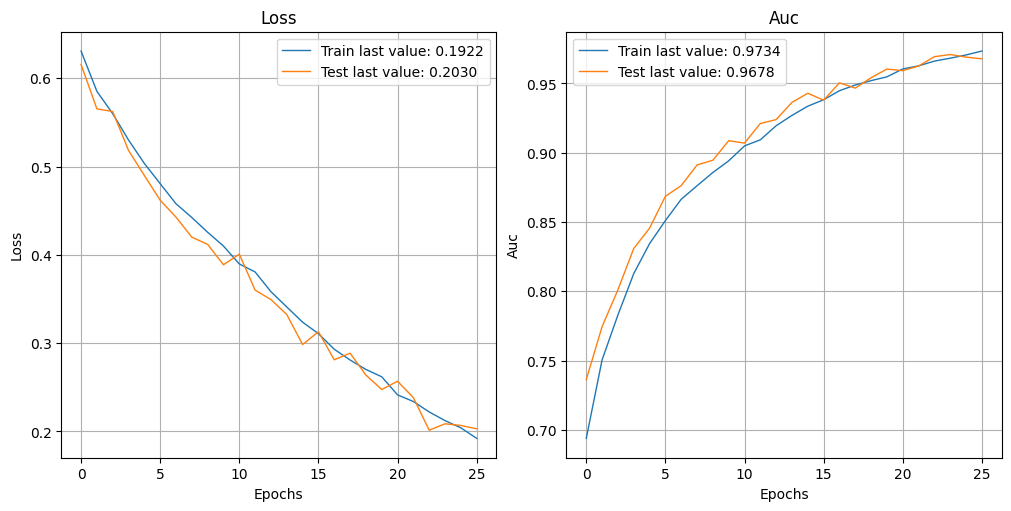



**Start Trials .........................................**

>## Install some Packages

In [1]:
!pip install plot_keras_history

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 34.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9470 sha256=1570ef710564599e2558bf008fea7afa74730ad8b1a2ea8de96756045093fb18
  Stored in directory: /root/.cache/pip/wheels/aa/0a/0f/0775c812151040fb695c0890d902810a9d69e1db50181e5328
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320515 sha256=bf0d3bf56f7ebe0f11841f1562e62eb64aafbc35e8b9c1559a1089986f05eb6a
  Stored in directory: /root/.cache/pip/wheels/d2/50/d6/95e7c7713c3c1609e30a394d7431ffc11e4f7deb82d13ffceb
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl siz

In [2]:
# install kaggle package
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Read SDF format data**

In [3]:
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [5]:
#importing libraries
import numpy as np   
# IPython/Jupyter Notebook progressbar decorator for iterators.
from tqdm.notebook import tqdm 

# fun. to read sdf file, the chemical composition of a molecule is saved as (structure data file)
def read_sdf(file):
    with open(file, 'r') as rf:   #opening the file
        content = rf.read()       #reading the contents of the file
    # Split the read file by delimiter $$$$ thus splitting each molecule in an array
    samples = content.split('$$$$') 
    
    #fun. to read each molecule configuration
    def parse_sample(s):
        lines = s.splitlines()    #splitting the text data to lines
        links = []                #empty array for links
        nodes = []                #empty array for nodes
        label = 0
        #loop over each line
        for l in lines:           
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            # for Atom block 
            if l.startswith('    '):   
                feature = l.split()
                #node feature (atom) as O,C etc.
                node = feature[3] 
                #appending nodes    
                nodes.append(node) 
            # bond block tells about connections between atoms   
            elif l.startswith(' '):   
                # splitting line
                lnk = l.split()       
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    #appending links
                    links.append((int(lnk[0])-1, int(lnk[1])-1,))
        return nodes, np.array(links), label #return nodes, links and label
    # parse_sample for each molecule
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]  

In [13]:
from sklearn.model_selection import train_test_split
#reading train.sdf file
train_data = read_sdf('/content/train (1).sdf')
#splitting the train data
train_data ,validation_data = train_test_split(data_train, test_size=0.15,)

  0%|          | 0/25024 [00:00<?, ?it/s]

In [14]:
#reading test file
test_data  = read_sdf('/content/test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

**Visualizing Samples**

**There are three elements in each sample array:**

The first part contains text data on the atoms.

The second element contains information about the connections.

The third element contains information about the labels for each molecule.

In [10]:
# libraries for displaying network of molecule
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [11]:
# fun. to visualize the compound graph atoms are given as nodes the connections are defined as edges

def visualize(sample):
    G=nx.Graph() #initiating an instance of Graph
    nodes = sample[0] #atoms as nodes
    edges = sample[1] #connections as edges
    #create dictionary for labels of the nodes
    labeldict={} 
    #create array for each node color
    node_color=[] 
    for i,n in enumerate(nodes): #for each node in the sample
        G.add_node(i)   #adding node to the graph each node as (0,1,2..)
        labeldict[i]=n  #dictionary building with [key,value] as [0:'C']
        node_color.append(colors[hash(n)%len(colors)]) #color coding

    # a list of nodes for each edge by adding egde to the graph from one connection to other connection
    for e in edges:
        G.add_edge(e[0], e[1])

    #drawing the graph with labels for nodes as atoms and connections as edges    
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    #returns graph
    return G

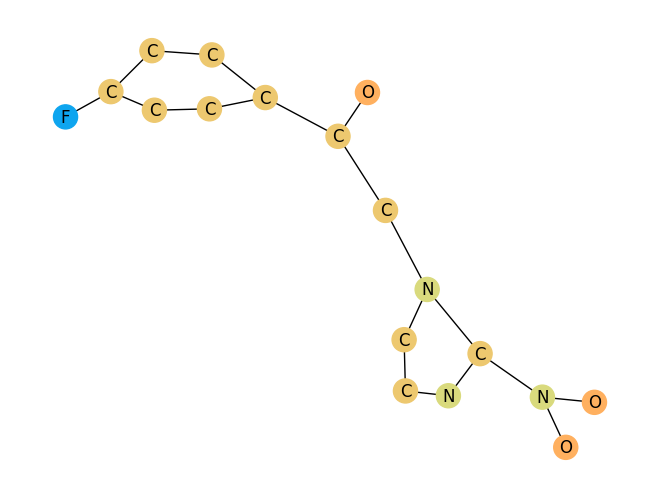

In [15]:
#displaying one sample
plt.clf()
visualize(train_data[1])

In [23]:
n=len(train_data)
m=len(test_data)

In [24]:
print('length of train_data:', len(train_data))
print('length of train_data[0]:', len(train_data[0]))
print('length of train_data[n-1]:', len(train_data[n-1]))
print('length of test_data:', len(test_data))
print('length of test_data[0]:', len(test_data[0]))
print('length of test_data[m-1]:', len(test_data[m-1]))

length of train_data: 21270
length of train_data[0]: 3
length of train_data[n-1]: 3
length of test_data: 12326
length of test_data[0]: 3
length of test_data[m-1]: 3


**Preprocessing**

Tokenizing the nodes(atoms)

In [27]:
#Tokenizer importing 
from tensorflow.keras.preprocessing.text import Tokenizer

#vocabulary size
max_vocab = 500
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in train_data]
#training tokenizer
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [28]:
#importing libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
# random seed
random.seed(0) 


# fun. to prepare single batch set Samples represents the batch of data
def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples] # Nodes characters array
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)   # tokenizing the sample nodes
    sample_nodes = pad_sequences(sample_nodes, padding='post')  # pad_sequences for each sample node with post padding
    max_nodes_len = np.shape(sample_nodes)[1] #shape: (num of samples, number of nodes) 
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]  #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0] #make sure all elements are non-zero
    # definition for segmented_ids
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]  
    
    all_nodes = np.reshape(sample_nodes, -1)  #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)         #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    #returns a dictionary of features(data,edges,node2grah) and label
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples]) 


#generating batch with given btch_size
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:                 #infinity loop
        dataset = list(dataset) #data in the array
        if shuffle:             # if shuffle is True
            random.shuffle(dataset) #randomly shuffling
        l = len(dataset)  #length of dataset
        for ndx in range(0, l, batch_size):  #loop for  creating batches from given dataset
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] #creating batch samples with given batch_size
            yield prepare_single_batch(batch_samples)   #returning a generator with prepared batches
        if not repeat:  #breaking loop if repeat is false
            break

In [29]:
# showing one batch:
for train_batch in gen_batch(train_data, batch_size=10):
    for k,v in train_batch[0].items(): #k: labels, v: values
        print(k)        
        print(v)
        print("Shape is "+str(np.shape(v)))
        pass
    print('label', train_batch[1])
    break

data
[4 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5
 4 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2
 2 2 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 4 6 6 6
 2 2 2 3 3 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 2 2 2
 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 5 5 4 4 2 2
 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 3 3 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 4 4 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 3 3 3 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Shape is (360,)
edges
[[  0   6]
 [  0  11]
 [  1   5]
 [  2   5]
 [  3   6]
 [  3   7]
 [  3   8]
 [  4   7]
 [  4   9]
 [  5  16]
 [  6  10]
 [  7  11]
 [  8   9]
 [  8  12]
 [  9  13]
 [ 10  14]
 [ 10  15]
 [ 12  17]
 [ 13  20]
 [ 14  18]
 [ 15  19]
 [ 16  18]


In [30]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

#for deep Graph Neural Network
from tf2_gnn.layers.gnn import GNN, GNNInput

#GGNN, RGCN,RGAT, RGIN, GNN-Edge-MLP, GNN-FiLM
from  tf2_gnn.layers.message_passing import gnn_edge_mlp,gnn_film,rgat,rgin,rgcn,ggnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.0/388.0 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.9/173.9 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 6.0 MB/s eta 0:00:00


In [31]:
#importing important libraries
import tensorflow as tf
from tensorflow.math import segment_mean # to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model # layers and model
from tensorflow.keras.layers import Embedding, Dense # layers
from tensorflow.keras.optimizers import Adam # optimizer


# The GNN layer takes a GNNInput named tuple as input, which encapsulates initial node features, adjacency lists, and auxiliary information.
#Input layer for nodes (tokenized text data) , eg. [440]
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input layer for edge data, eg. [257,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input layer for node2graph ids , eg. [440]
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding layer over data with each token embedded as  size vector eg. [440,50]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 #defining hidden dimension of the gnn layer
#params['message_calculation_class']

#gnn layer with defined hyperparameters
gnn_layer = GNN(params)

#gnn output layer 
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

#final dense layer with sigmoid
pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

#building model inputs are data,edges and node2graph
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
#printing summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

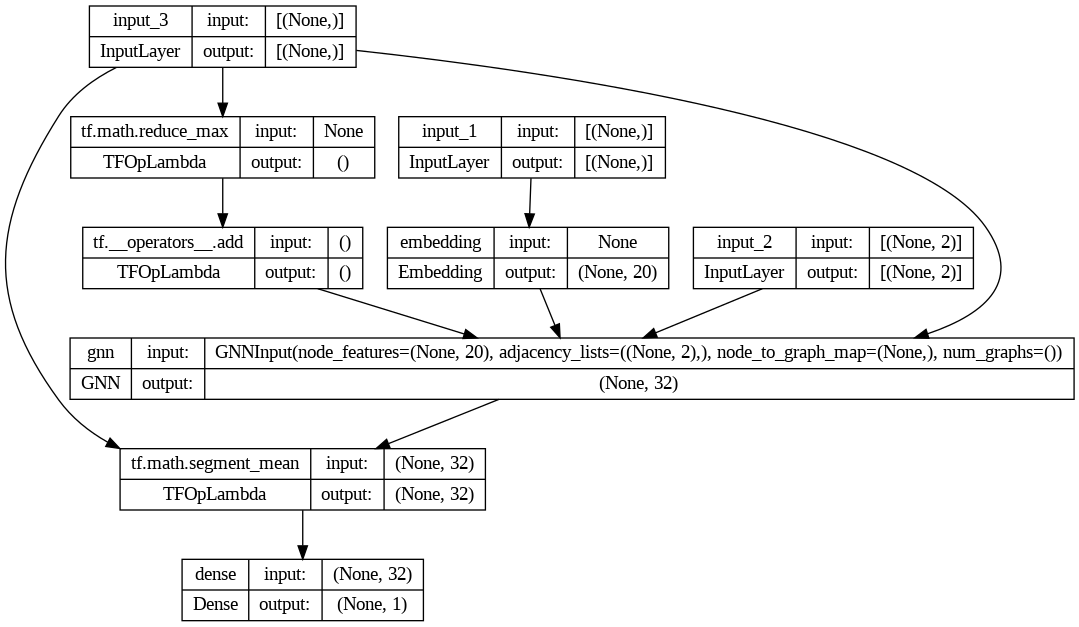

In [32]:
# This enables in-line display of the model plots in notebooks.
tf.keras.utils.plot_model(model, show_shapes=True)

In [33]:
# we will use Adam Optimizer.
model.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [34]:
%%time
import math

batch_size = 16
#math.ceil: returns the smallest integral value greater than the number
num_batchs = math.ceil(len(train_data) / batch_size) #no. of batches for training data
num_batchs_validation = math.ceil(len(validation_data) / batch_size) #no. of batches for validation data

history = model.fit(
    gen_batch(
        train_data, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_data, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/10
1330/1330 [==============================] - 30s 15ms/step - loss: 0.2341 - auc: 0.4860 - val_loss: 0.1805 - val_auc: 0.6202
Epoch 2/10
1330/1330 [==============================] - 24s 18ms/step - loss: 0.1923 - auc: 0.6313 - val_loss: 0.1911 - val_auc: 0.6760
Epoch 3/10
1330/1330 [==============================] - 32s 24ms/step - loss: 0.1890 - auc: 0.6529 - val_loss: 0.1794 - val_auc: 0.7040
Epoch 4/10
1330/1330 [==============================] - 20s 15ms/step - loss: 0.1857 - auc: 0.6775 - val_loss: 0.1684 - val_auc: 0.7115
Epoch 5/10
1330/1330 [==============================] - 26s 19ms/step - loss: 0.1841 - auc: 0.6921 - val_loss: 0.1656 - val_auc: 0.7183
Epoch 6/10
1330/1330 [==============================] - 32s 24ms/step - loss: 0.1807 - auc: 0.7109 - val_loss: 0.1608 - val_auc: 0.7403
Epoch 7/10
1330/1330 [==============================] - 29s 22ms/step - loss: 0.1784 - auc: 0.7246 - val_loss: 0.1696 - val_auc: 0.7291
Epoch 8/10
1330/1330 [==========================

> ## Virtualization Method

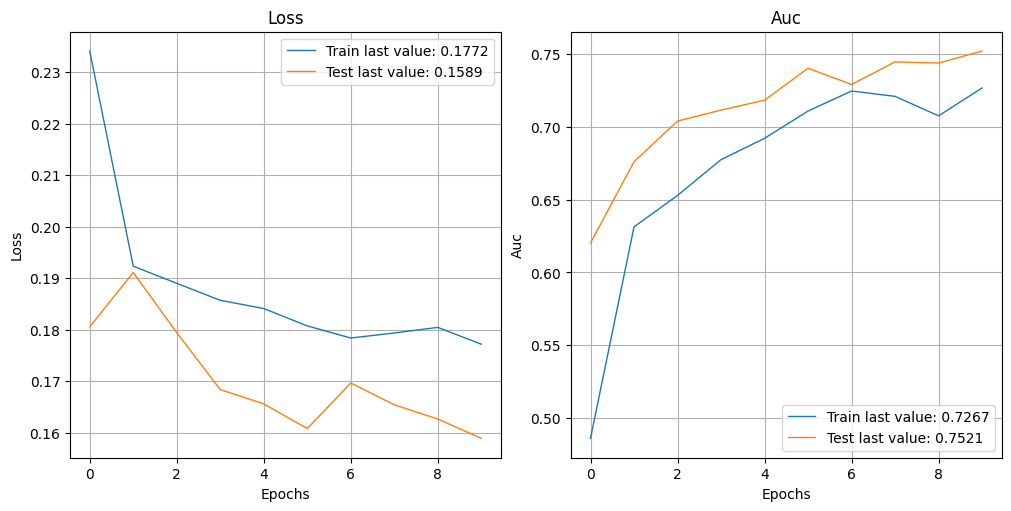

In [35]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

def Virt_fun(history):
  # show the history of our model
  show_history(history)
  plot_history(history, path="standard.png")
  plt.close()

# calling this fun.
Virt_fun(history)

In [36]:
# to predict our model
y_pred = model.predict(gen_batch(test_data, batch_size=16, shuffle=False))
# to reshape y_pred
y_pred = np.reshape(y_pred, -1)
y_pred.shape

771/771 [==============================] - 5s 6ms/step


(12326,)

In [37]:
y_pred

array([0.11819909, 0.06146498, 0.0141397 , ..., 0.02190467, 0.05893585,
       0.02070865], dtype=float32)

**observation:**

 I can see there is a lot of overfitting because the data is very unbalanced.

may be  if we make the data balanced the accuracy(AUC) would be better



In [38]:
import pandas as pd 
# create datafram with y_pred & id columns
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
# convert the dataframe to csv file
submission.to_csv('sample_submission_trial_start.csv')

In [39]:
from google.colab import files
# to download the csv file
files.download("sample_submission_trial_start.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Trial_1 with GGNN**

In general, Graph Neural Networks (GNN) refer to the general concept of applying neural networks (NNs) on graphs

> (Graph Neural Networks)
Some literature may refer to this original GNN model as Recurrent Graph Neural Network (RecGNN). In this section, we stay with the term GNN. The general concept of GNN is to exchange information (message) constantly with its neighbors until a stable equilibrium is reached. This behaves similarly to an RNN as weights are shared in each recurrent step. In contrast, GCN does not share weights between their hidden layers.

Gated Graph Neural Network (GGNN)
In RNN, the hidden state is updated by the input and the last hidden state.
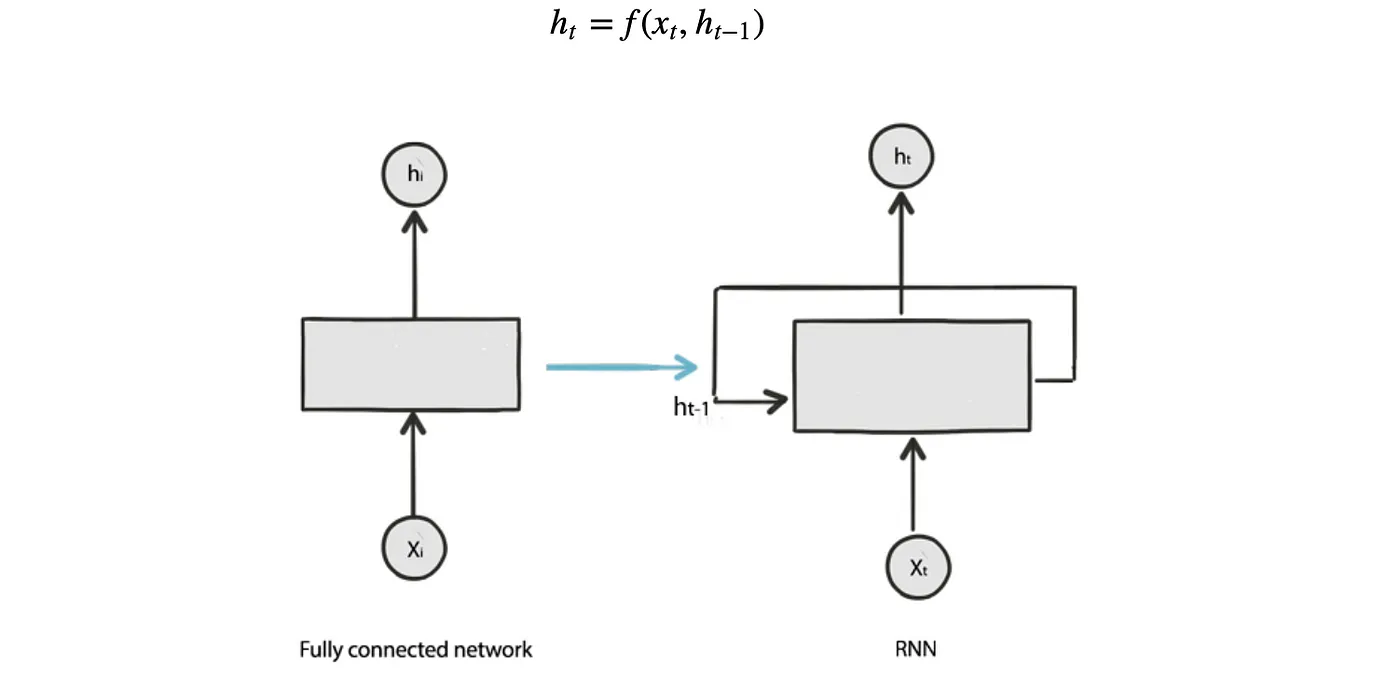

In GGNN, it applies the following equations in updating the hidden state.
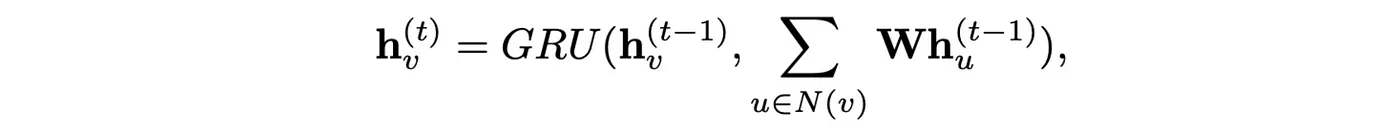

where hᵥ⁽⁰⁾ = xᵥ and xᵥ is the annotation for node v (some kind of initial node labeling depending on the problem domains). Here, GGNN applies GRU (equation 6) to its previous hidden state of node v and the new hidden state updates. The following is the exact equation used in the paper for your reference. It looks complicated but it is simply the GRU version on GNN if you look into the details.

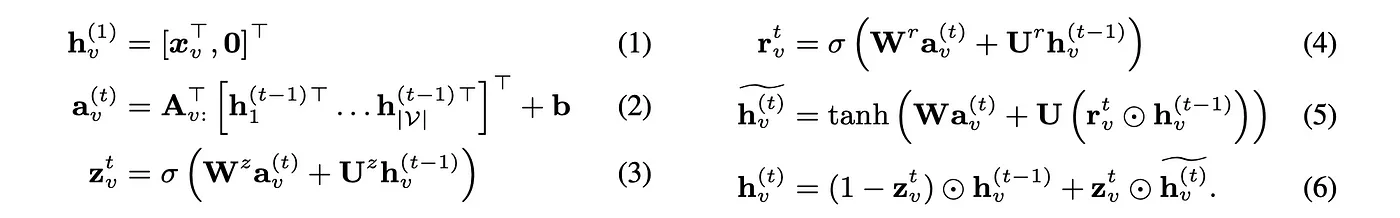
where W and U are learnable parameters, z and r are the gates and A indicates the connectivity between nodes.
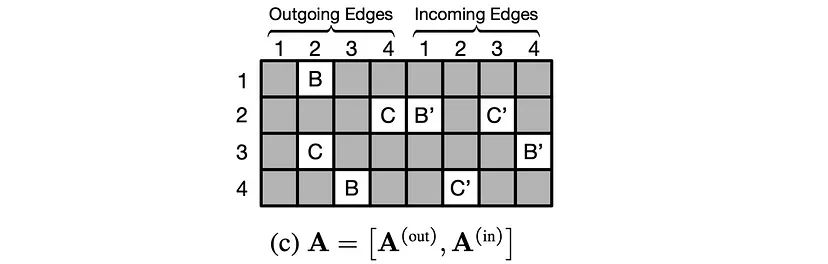

refrence:
https://jonathan-hui.medium.com/graph-neural-networks-gnn-gae-stgnn-1ac0b5c99550





## Read SDF format data (structured-data format)

In [40]:
#importing libraries
import numpy as np   
# IPython/Jupyter Notebook progressbar decorator for iterators.
from tqdm.notebook import tqdm 

# fun. to read sdf file, the chemical composition of a molecule is saved as (structure data file)
def read_sdf(file):
    with open(file, 'r') as rf:   #opening the file
        content = rf.read()       #reading the contents of the file
    # Split the read file by delimiter $$$$ thus splitting each molecule in an array
    samples = content.split('$$$$') 
    
    #fun. to read each molecule configuration
    def parse_sample(s):
        lines = s.splitlines()    #splitting the text data to lines
        links = []                #empty array for links
        nodes = []                #empty array for nodes
        label = 0
        #loop over each line
        for l in lines:           
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            # for Atom block 
            if l.startswith('    '):   
                feature = l.split()
                #node feature (atom) as O,C etc.
                node = feature[3] 
                #appending nodes    
                nodes.append(node) 
            # bond block tells about connections between atoms   
            elif l.startswith(' '):   
                # splitting line
                lnk = l.split()       
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    #appending links
                    links.append((int(lnk[0])-1, int(lnk[1])-1,))
        return nodes, np.array(links), label #return nodes, links and label
    # parse_sample for each molecule
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]  

In [42]:
from sklearn.model_selection import train_test_split
#reading train.sdf file
training_set = read_sdf('/content/train (1).sdf')
#splitting the train data
training_set, validation_set = train_test_split(training_set, test_size=0.15,)

  0%|          | 0/25024 [00:00<?, ?it/s]

In [43]:
#reading test file
testing_set  = read_sdf('/content/test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

## Visualizing/Inspecting a Sample

In [44]:
# libraries for displaying network of molecule
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [45]:
# fun. to visualize the compound graph atoms are given as nodes the connections are defined as edges

def visualize(sample):
    G=nx.Graph() #initiating an instance of Graph
    nodes = sample[0] #atoms as nodes
    edges = sample[1] #connections as edges
    #create dictionary for labels of the nodes
    labeldict={} 
    #create array for each node color
    node_color=[] 
    for i,n in enumerate(nodes): #for each node in the sample
        G.add_node(i)   #adding node to the graph each node as (0,1,2..)
        labeldict[i]=n  #dictionary building with [key,value] as [0:'C']
        node_color.append(colors[hash(n)%len(colors)]) #color coding

    # a list of nodes for each edge by adding egde to the graph from one connection to other connection
    for e in edges:
        G.add_edge(e[0], e[1])

    #drawing the graph with labels for nodes as atoms and connections as edges    
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    #returns graph
    return G

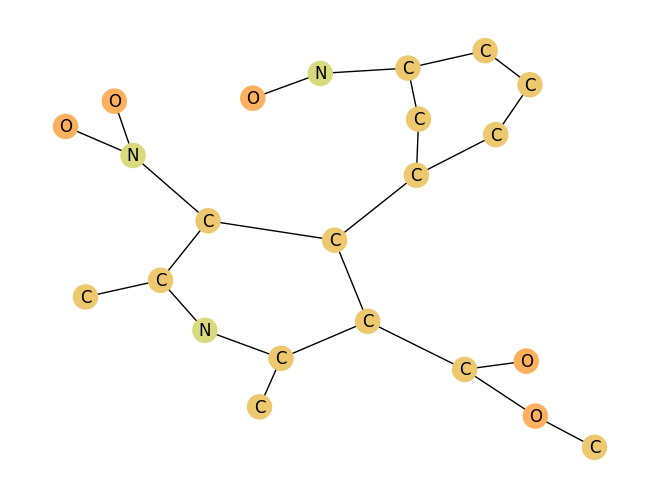

In [46]:
#displaying one sample
plt.clf()
visualize(training_set[0])

In [47]:
print('length of training_set:', len(training_set))
print('length of traiing_set[0]:', len(training_set[0]))
print('length of testing_set:', len(testing_set))
print('length of testing_set[0]:', len(testing_set[0]))

length of training_set: 21270
length of traiing_set[0]: 3
length of testing_set: 12326
length of testing_set[0]: 3


## Preprocessing
> * Tokenizing the nodes(atoms)
> * With Different vocabulary size

In [48]:
#Tokenizer importing 
from tensorflow.keras.preprocessing.text import Tokenizer

#vocabulary size
max_vocab = 400
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in training_set]
#training tokenizer
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [49]:
#importing libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
# random seed
random.seed(0) 


# fun. to prepare single batch set Samples represents the batch of data
def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples] # Nodes characters array
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)   # tokenizing the sample nodes
    sample_nodes = pad_sequences(sample_nodes, padding='post')  # pad_sequences for each sample node with post padding
    max_nodes_len = np.shape(sample_nodes)[1] #shape: (num of samples, number of nodes) 
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]  #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0] #make sure all elements are non-zero
    # definition for segmented_ids
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]  
    
    all_nodes = np.reshape(sample_nodes, -1)  #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)         #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    #returns a dictionary of features(data,edges,node2grah) and label
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples]) 


#generating batch with given btch_size
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:                 #infinity loop
        dataset = list(dataset) #data in the array
        if shuffle:             # if shuffle is True
            random.shuffle(dataset) #randomly shuffling
        l = len(dataset)  #length of dataset
        for ndx in range(0, l, batch_size):  #loop for  creating batches from given dataset
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] #creating batch samples with given batch_size
            yield prepare_single_batch(batch_samples)   #returning a generator with prepared batches
        if not repeat:  #breaking loop if repeat is false
            break

In [50]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=10):
    for k,v in train_batch[0].items(): #k: labels, v: values
        print(k)        
        print(v)
        print("Shape is "+str(np.shape(v)))
        pass
    print('label', train_batch[1])
    break

data
[11  2  2  2  2  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  0  0  0  4  3  3  3  3  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  7  4  4  2  2  2  2  3
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0
  2  2  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  2  2  2  3  3  3  3  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  3  3  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0
  4  2  2  3  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  0  0  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 38  7  4  4  4  4  4  4
  3  3  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0
  2  2  2  2  2  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0
  0  0  0  0  0  0  0  0]
Shape is (320,)
edge

In [51]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

#for deep Graph Neural Network
from tf2_gnn.layers.gnn import GNN, GNNInput

#GGNN, RGCN,RGAT, RGIN, GNN-Edge-MLP, GNN-FiLM
from  tf2_gnn.layers.message_passing import gnn_edge_mlp,gnn_film,rgat,rgin,rgcn,ggnn

In [52]:
#importing tensorflow and other libraries
import tensorflow as tf
from tensorflow.math import segment_mean # to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model # layers and model
from tensorflow.keras.layers import Embedding, Dense # layers
from tensorflow.keras.optimizers import Adam # optimizer


# The GNN layer takes a GNNInput named tuple as input, which encapsulates initial node features, adjacency lists, and auxiliary information.
#Input layer for nodes (tokenized text data) , eg. [440]
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input layer for edge data, eg. [257,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input layer for node2graph ids , eg. [440]
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding layer over data with each token embedded as  size vector eg. [440,50]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'GGNN'
params["hidden_dim"] = 128 #defining hidden dimension of the gnn layer
params["num_layers"] = 8
params["dense_every_num_layers"] = 8
params["num_heads"] = 4
params["num_aggr_MLP_hidden_layers"] = 1
params["film_parameter_MLP_hidden_layers"] = 1

#gnn layer with defined hyperparameters
gnn_layer = GNN(params)

#gnn output layer 
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

#final dense layer with sigmoid
pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

#building model inputs are data,edges and node2graph
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
#printing summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []      

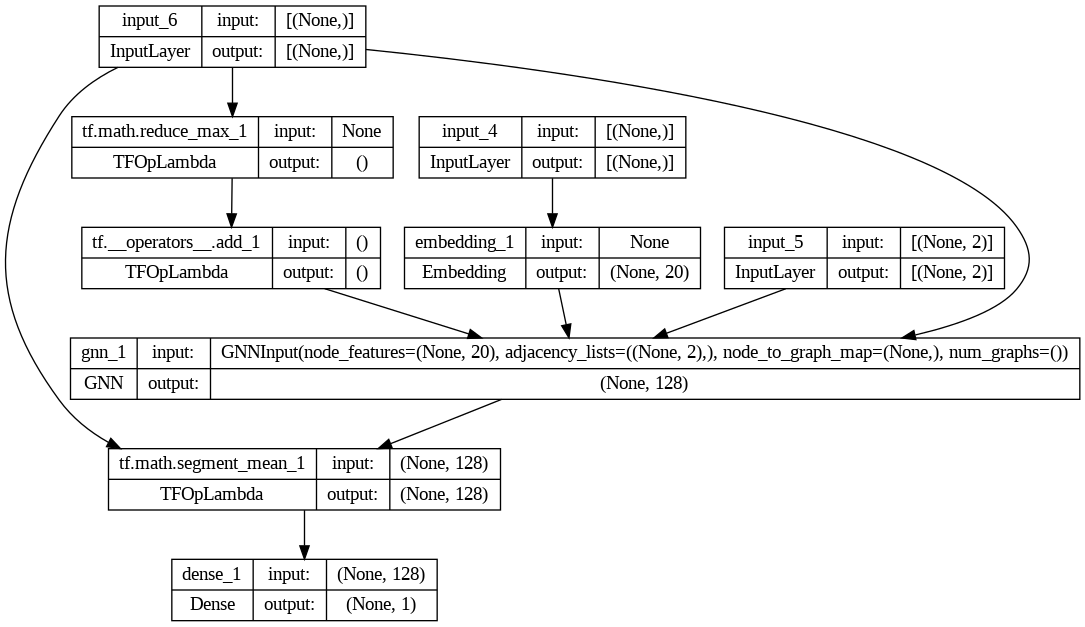

In [53]:
# This enables in-line display of the model plots in notebooks.
tf.keras.utils.plot_model(model, show_shapes=True)

In [54]:
# we will use Adam Optimizer.
model.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [55]:
%%time
import math

batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
num_batchs = math.ceil(len(training_set) / batch_size) #no. of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) #no. of batches for validation data

# fit our model with 20 epocks and different batch_size.
history = model.fit(
    # gen_batch for training data set
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=20,
    # gen_batch for validation data set
    validation_data=gen_batch(validation_set, batch_size=32, repeat=True),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5, restore_best_weights=True,mode='max')],
)

Epoch 1/20
665/665 [==============================] - 59s 55ms/step - loss: 0.1998 - auc: 0.5969 - val_loss: 0.1920 - val_auc: 0.6270
Epoch 2/20
665/665 [==============================] - 23s 35ms/step - loss: 0.1867 - auc: 0.6569 - val_loss: 0.2007 - val_auc: 0.6457
Epoch 3/20
665/665 [==============================] - 24s 36ms/step - loss: 0.1842 - auc: 0.6618 - val_loss: 0.1857 - val_auc: 0.6651
Epoch 4/20
665/665 [==============================] - 24s 36ms/step - loss: 0.1824 - auc: 0.6853 - val_loss: 0.1874 - val_auc: 0.6929
Epoch 5/20
665/665 [==============================] - 26s 39ms/step - loss: 0.1841 - auc: 0.6743 - val_loss: 0.1849 - val_auc: 0.6924
Epoch 6/20
665/665 [==============================] - 24s 36ms/step - loss: 0.1794 - auc: 0.7016 - val_loss: 0.1798 - val_auc: 0.6833
Epoch 7/20
665/665 [==============================] - 24s 36ms/step - loss: 0.1781 - auc: 0.7109 - val_loss: 0.1867 - val_auc: 0.6865
Epoch 8/20
665/665 [==============================] - 24s 36ms

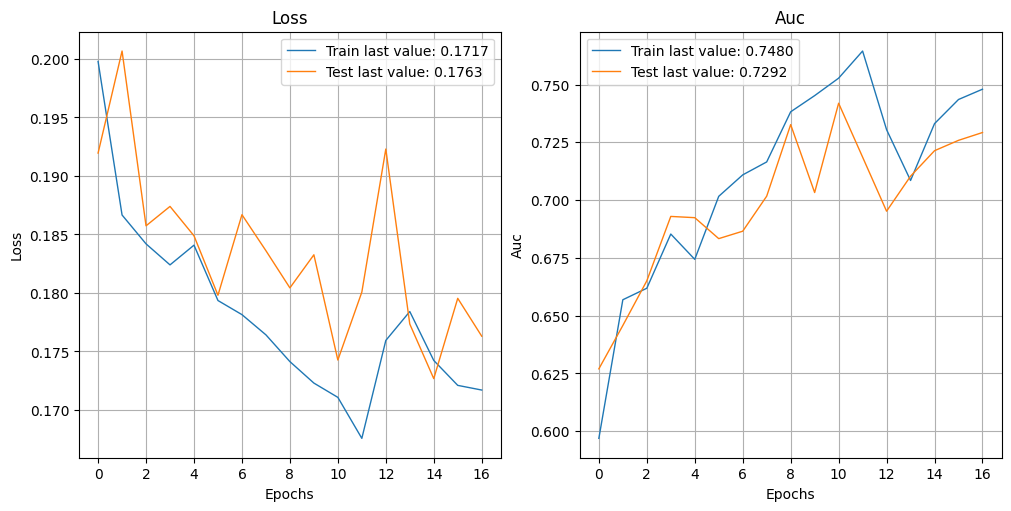

In [56]:
# just call this cell
Virt_fun(history)

In [57]:
# to predict our model
y_pred = model.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
# to reshape y_pred
y_pred = np.reshape(y_pred, -1)
y_pred.shape

771/771 [==============================] - 7s 9ms/step


(12326,)

In [58]:
y_pred

array([0.19991441, 0.02759106, 0.04631484, ..., 0.01412988, 0.00908792,
       0.05826825], dtype=float32)

In [241]:
import pandas as pd 
# create datafram with y_pred & id columns
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
# convert the dataframe to csv file
submission.to_csv('sample_submission_trial_1.csv')

In [242]:
from google.colab import files
# to download the csv file
files.download("sample_submission_trial_1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**observation:**

 I can see there is a lot of overfitting because the data is very unbalanced.

may be  if we make the data balanced the accuracy(AUC) would be better

**give me accuracy in kaggle: .83342 seems to be good**

**Trial_2 with RGAT**
**RGCN, attention, graph convolutional networks, semi-supervised learning, graph classification, molecules**
reference: https://github.com/babylonhealth/

https://openreview.net/forum?id=Bklzkh0qFm



> ![](https://raw.githubusercontent.com/babylonhealth/rgat/master/images/argat.png)




## Read SDF format data (structured-data format)

In [59]:
#importing libraries
import numpy as np   
# IPython/Jupyter Notebook progressbar decorator for iterators.
from tqdm.notebook import tqdm 

# fun. to read sdf file, the chemical composition of a molecule is saved as (structure data file)
def read_sdf(file):
    with open(file, 'r') as rf:   #opening the file
        content = rf.read()       #reading the contents of the file
    # Split the read file by delimiter $$$$ thus splitting each molecule in an array
    samples = content.split('$$$$') 
    
    #fun. to read each molecule configuration
    def parse_sample(s):
        lines = s.splitlines()    #splitting the text data to lines
        links = []                #empty array for links
        nodes = []                #empty array for nodes
        label = 0
        #loop over each line
        for l in lines:           
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            # for Atom block 
            if l.startswith('    '):   
                feature = l.split()
                #node feature (atom) as O,C etc.
                node = feature[3] 
                #appending nodes    
                nodes.append(node) 
            # bond block tells about connections between atoms   
            elif l.startswith(' '):   
                # splitting line
                lnk = l.split()       
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    #appending links
                    links.append((int(lnk[0])-1, int(lnk[1])-1,))
        return nodes, np.array(links), label #return nodes, links and label
    # parse_sample for each molecule
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]  

In [62]:
from sklearn.model_selection import train_test_split
#reading train.sdf file
training_set = read_sdf('/content/train (1).sdf')
#splitting the train data
training_set, validation_set = train_test_split(training_set, test_size=0.15,)

  0%|          | 0/25024 [00:00<?, ?it/s]

In [63]:
#reading test file
testing_set  = read_sdf('/content/test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

**Visualizing a Sample**

In [65]:
# libraries for displaying network of molecule
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [66]:
# fun. to visualize the compound graph atoms are given as nodes the connections are defined as edges

def visualize(sample):
    G=nx.Graph() #initiating an instance of Graph
    nodes = sample[0] #atoms as nodes
    edges = sample[1] #connections as edges
    #create dictionary for labels of the nodes
    labeldict={} 
    #create array for each node color
    node_color=[] 
    for i,n in enumerate(nodes): #for each node in the sample
        G.add_node(i)   #adding node to the graph each node as (0,1,2..)
        labeldict[i]=n  #dictionary building with [key,value] as [0:'C']
        node_color.append(colors[hash(n)%len(colors)]) #color coding

    # a list of nodes for each edge by adding egde to the graph from one connection to other connection
    for e in edges:
        G.add_edge(e[0], e[1])

    #drawing the graph with labels for nodes as atoms and connections as edges    
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    #returns graph
    return G

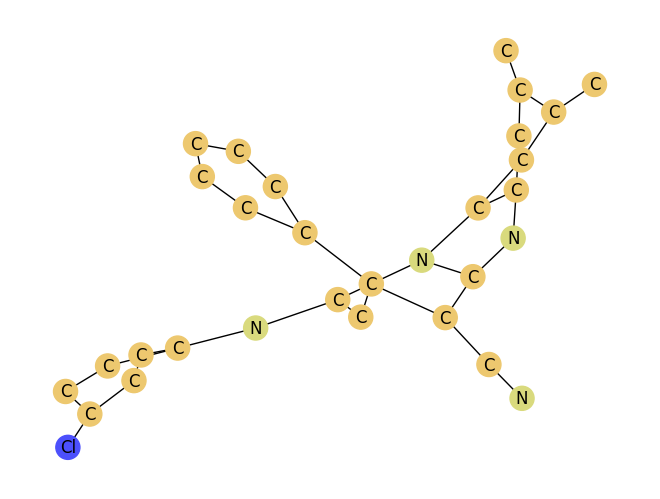

In [67]:
#displaying one sample
plt.clf()
visualize(training_set[1])

In [68]:
print('length of training_set:', len(training_set))
print('length of traiing_set[0]:', len(training_set[0]))
print('length of testing_set:', len(testing_set))
print('length of testing_set[0]:', len(testing_set[0]))

length of training_set: 21270
length of traiing_set[0]: 3
length of testing_set: 12326
length of testing_set[0]: 3


**Preprocessing**

> * Tokenizing the nodes(atoms)
> * With Different vocabulary size

In [69]:
#Tokenizer importing 
from tensorflow.keras.preprocessing.text import Tokenizer

#vocabulary size
max_vocab = 400
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in training_set]
#training tokenizer
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [70]:
#importing libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
# random seed
random.seed(0) 


# fun. to prepare single batch set Samples represents the batch of data
def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples] # Nodes characters array
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)   # tokenizing the sample nodes
    sample_nodes = pad_sequences(sample_nodes, padding='post')  # pad_sequences for each sample node with post padding
    max_nodes_len = np.shape(sample_nodes)[1] #shape: (num of samples, number of nodes) 
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]  #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0] #make sure all elements are non-zero
    # definition for segmented_ids
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]  
    
    all_nodes = np.reshape(sample_nodes, -1)  #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)         #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    #returns a dictionary of features(data,edges,node2grah) and label
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples]) 


#generating batch with given btch_size
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:                 #infinity loop
        dataset = list(dataset) #data in the array
        if shuffle:             # if shuffle is True
            random.shuffle(dataset) #randomly shuffling
        l = len(dataset)  #length of dataset
        for ndx in range(0, l, batch_size):  #loop for  creating batches from given dataset
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] #creating batch samples with given batch_size
            yield prepare_single_batch(batch_samples)   #returning a generator with prepared batches
        if not repeat:  #breaking loop if repeat is false
            break

In [71]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=10):
    for k,v in train_batch[0].items(): #k: labels, v: values
        print(k)        
        print(v)
        print("Shape is "+str(np.shape(v)))
        pass
    print('label', train_batch[1])
    break

data
[4 2 2 2 2 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 4 3 3 3 3 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 4 2 2 2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 3 3 3 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 2 3 3 3 3 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Shape is (400,)
edges
[[  0   8]
 [  0   9]
 [  1   7]
 [  1  10]
 [  2   6]
 [  2  11]
 [  3   7]
 [  4   6]
 [  5   6]
 [  5   7]
 [  5   8]
 [  5   9]
 [ 10  12]
 [ 11  13]
 [ 40  

In [72]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

#for deep Graph Neural Network
from tf2_gnn.layers.gnn import GNN, GNNInput

#GGNN, RGCN,RGAT, RGIN, GNN-Edge-MLP, GNN-FiLM
from  tf2_gnn.layers.message_passing import gnn_edge_mlp,gnn_film,rgat,rgin,rgcn,ggnn

In [73]:
#importing tensorflow and other libraries
import tensorflow as tf
from tensorflow.math import segment_mean # to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model # layers and model
from tensorflow.keras.layers import Embedding, Dense # layers
from tensorflow.keras.optimizers import Adam # optimizer


# The GNN layer takes a GNNInput named tuple as input, which encapsulates initial node features, adjacency lists, and auxiliary information.
#Input layer for nodes (tokenized text data) , eg. [440]
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input layer for edge data, eg. [257,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input layer for node2graph ids , eg. [440]
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding layer over data with each token embedded as  size vector eg. [440,50]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'rgat'
params["hidden_dim"] = 32 #defining hidden dimension of the gnn layer
params["num_heads"] = 4
params["num_layers"] = 8
params["dense_every_num_layers"] = 8

#gnn layer with defined hyperparameters
gnn_layer = GNN(params)

#gnn output layer 
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

#final dense layer with sigmoid
pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

#building model inputs are data,edges and node2graph
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
#printing summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []        

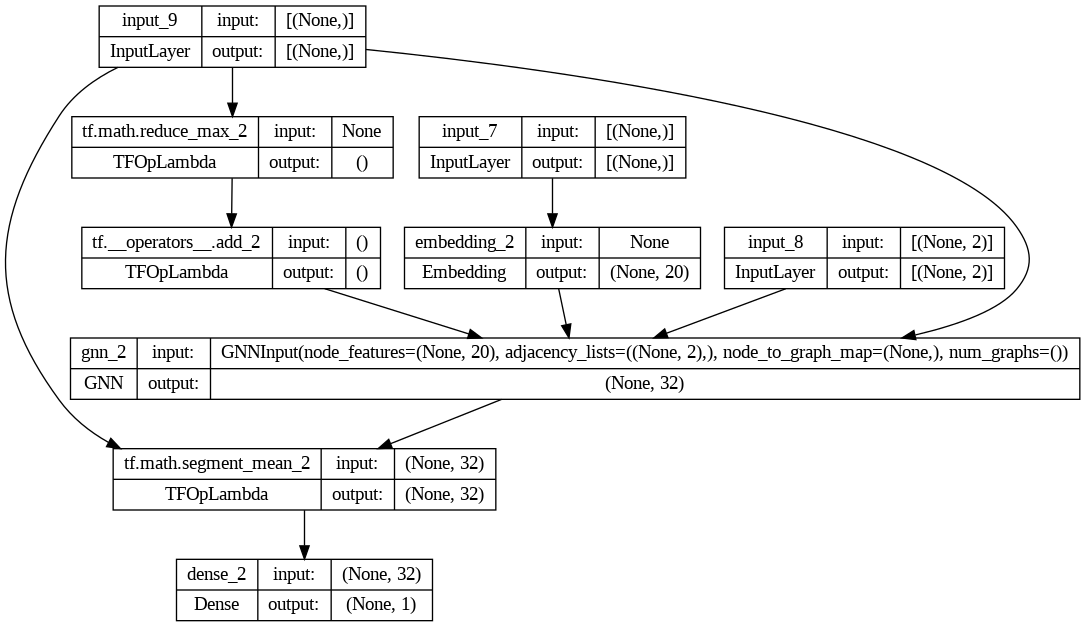

In [74]:
# This enables in-line display of the model plots in notebooks.
tf.keras.utils.plot_model(model, show_shapes=True)

In [75]:
# use Adam Optimizer.
model.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [76]:
%%time
import math

batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
num_batchs = math.ceil(len(training_set) / batch_size) #no. of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) #no. of batches for validation data

# fit our model with 20 epocks and different batch_size.
model.fit(
    # gen_batch for training data set
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=20,
    # gen_batch for validation data set
    validation_data=gen_batch(validation_set, batch_size=32, repeat=True),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5, restore_best_weights=True,mode='max')],
)

Epoch 1/20
665/665 [==============================] - 65s 58ms/step - loss: 0.2544 - auc: 0.4900 - val_loss: 0.2004 - val_auc: 0.6338
Epoch 2/20
665/665 [==============================] - 36s 55ms/step - loss: 0.1944 - auc: 0.6225 - val_loss: 0.1945 - val_auc: 0.6327
Epoch 3/20
665/665 [==============================] - 38s 58ms/step - loss: 0.1878 - auc: 0.6633 - val_loss: 0.1928 - val_auc: 0.6827
Epoch 4/20
665/665 [==============================] - 36s 55ms/step - loss: 0.1828 - auc: 0.6929 - val_loss: 0.1900 - val_auc: 0.6859
Epoch 5/20
665/665 [==============================] - 45s 67ms/step - loss: 0.1787 - auc: 0.7118 - val_loss: 0.1884 - val_auc: 0.7073
Epoch 6/20
665/665 [==============================] - 39s 59ms/step - loss: 0.1768 - auc: 0.7152 - val_loss: 0.1870 - val_auc: 0.6843
Epoch 7/20
665/665 [==============================] - 43s 65ms/step - loss: 0.1760 - auc: 0.7257 - val_loss: 0.1750 - val_auc: 0.7374
Epoch 8/20
665/665 [==============================] - 38s 57ms

In [77]:
# to predict our model
y_pred = model.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
# to reshape y_pred
y_pred = np.reshape(y_pred, -1)
y_pred.shape

771/771 [==============================] - 8s 10ms/step


(12326,)

In [78]:
y_pred

array([0.36429602, 0.0327897 , 0.00557   , ..., 0.00719504, 0.10590111,
       0.0120692 ], dtype=float32)

In [79]:
import pandas as pd 
# create datafram with y_pred & id columns
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
# convert the dataframe to csv file
submission.to_csv('sample_submission_trial_2.csv')

In [80]:
from google.colab import files
# to download the csv file
files.download("sample_submission_trial_2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**observation:**

I can see there is a lot of overfitting because the data is very unbalanced.

may be if we make the data balanced the accuracy(AUC) would be better

give me accuracy in kaggle: 0.7766  not good

**Trial_3 with RGCN**

 Relational Graph Convolutional Networks extend the notion of the Graph Convolution Network (GCN). The layers of a GCN are a generalization of convolutional layers in a CNN where the data can have a dynamic number of neighbors instead of being fixed on a grid like the pixels of an image. Where GraphSAGE focuses on extending GCNs to generalize by using trainable aggregation functions, RGCN extends GCNs to operate on multigraphs, where there is more than one edge type. There are many variations on GCN layers and more being added all the time. 
 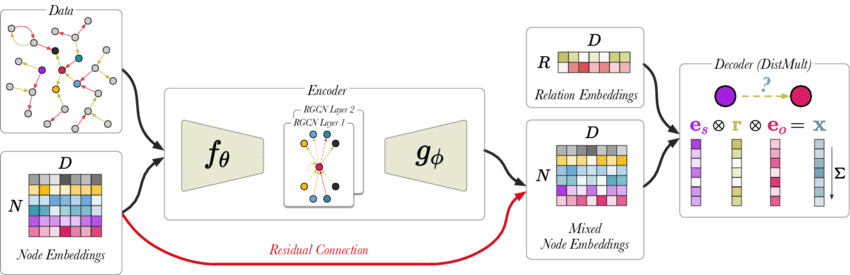
 refrence:
 
 https://sigopt.com/blog/what-is-a-relational-graph-convolutional-network-rgcn/





## Read SDF format data (structured-data format)

In [81]:
#importing libraries
import numpy as np   
# IPython/Jupyter Notebook progressbar decorator for iterators.
from tqdm.notebook import tqdm 

# fun. to read sdf file, the chemical composition of a molecule is saved as (structure data file)
def read_sdf(file):
    with open(file, 'r') as rf:   #opening the file
        content = rf.read()       #reading the contents of the file
    # Split the read file by delimiter $$$$ thus splitting each molecule in an array
    samples = content.split('$$$$') 
    
    #fun. to read each molecule configuration
    def parse_sample(s):
        lines = s.splitlines()    #splitting the text data to lines
        links = []                #empty array for links
        nodes = []                #empty array for nodes
        label = 0
        #loop over each line
        for l in lines:           
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            # for Atom block 
            if l.startswith('    '):   
                feature = l.split()
                #node feature (atom) as O,C etc.
                node = feature[3] 
                #appending nodes    
                nodes.append(node) 
            # bond block tells about connections between atoms   
            elif l.startswith(' '):   
                # splitting line
                lnk = l.split()       
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    #appending links
                    links.append((int(lnk[0])-1, int(lnk[1])-1,))
        return nodes, np.array(links), label #return nodes, links and label
    # parse_sample for each molecule
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]  

In [84]:
from sklearn.model_selection import train_test_split
#reading train.sdf file
training_set = read_sdf('/content/train (1).sdf')
#splitting the train data
training_set, validation_set = train_test_split(training_set, test_size=0.15,)

  0%|          | 0/25024 [00:00<?, ?it/s]

In [85]:
#reading test file
testing_set  = read_sdf('/content/test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

## Visualizing/Inspecting a Sample

In [86]:
# libraries for displaying network of molecule
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [87]:
# fun. to visualize the compound graph atoms are given as nodes the connections are defined as edges

def visualize(sample):
    G=nx.Graph() #initiating an instance of Graph
    nodes = sample[0] #atoms as nodes
    edges = sample[1] #connections as edges
    #create dictionary for labels of the nodes
    labeldict={} 
    #create array for each node color
    node_color=[] 
    for i,n in enumerate(nodes): #for each node in the sample
        G.add_node(i)   #adding node to the graph each node as (0,1,2..)
        labeldict[i]=n  #dictionary building with [key,value] as [0:'C']
        node_color.append(colors[hash(n)%len(colors)]) #color coding

    # a list of nodes for each edge by adding egde to the graph from one connection to other connection
    for e in edges:
        G.add_edge(e[0], e[1])

    #drawing the graph with labels for nodes as atoms and connections as edges    
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    #returns graph
    return G

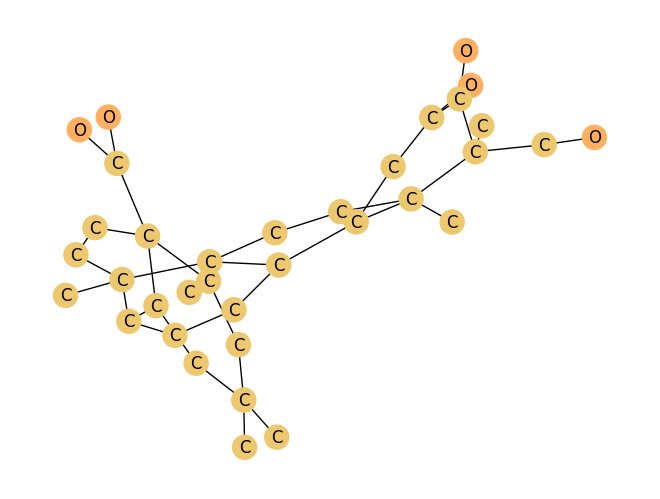

In [88]:
#displaying one sample
plt.clf()
visualize(training_set[0])

In [89]:
print('length of training_set:', len(training_set))
print('length of traiing_set[0]:', len(training_set[0]))
print('length of testing_set:', len(testing_set))
print('length of testing_set[0]:', len(testing_set[0]))

length of training_set: 21270
length of traiing_set[0]: 3
length of testing_set: 12326
length of testing_set[0]: 3


## Preprocessing
> * Tokenizing the nodes(atoms)
> * With Different vocabulary size

In [90]:
#Tokenizer importing 
from tensorflow.keras.preprocessing.text import Tokenizer

#vocabulary size
max_vocab = 400
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in training_set]
#training tokenizer
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [91]:
#importing libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
# random seed
random.seed(0) 


# fun. to prepare single batch set Samples represents the batch of data
def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples] # Nodes characters array
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)   # tokenizing the sample nodes
    sample_nodes = pad_sequences(sample_nodes, padding='post')  # pad_sequences for each sample node with post padding
    max_nodes_len = np.shape(sample_nodes)[1] #shape: (num of samples, number of nodes) 
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]  #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0] #make sure all elements are non-zero
    # definition for segmented_ids
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]  
    
    all_nodes = np.reshape(sample_nodes, -1)  #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)         #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    #returns a dictionary of features(data,edges,node2grah) and label
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples]) 


#generating batch with given btch_size
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:                 #infinity loop
        dataset = list(dataset) #data in the array
        if shuffle:             # if shuffle is True
            random.shuffle(dataset) #randomly shuffling
        l = len(dataset)  #length of dataset
        for ndx in range(0, l, batch_size):  #loop for  creating batches from given dataset
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] #creating batch samples with given batch_size
            yield prepare_single_batch(batch_samples)   #returning a generator with prepared batches
        if not repeat:  #breaking loop if repeat is false
            break

In [92]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=10):
    for k,v in train_batch[0].items(): #k: labels, v: values
        print(k)        
        print(v)
        print("Shape is "+str(np.shape(v)))
        pass
    print('label', train_batch[1])
    break

data
[4 6 6 2 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2
 2 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 4 4 2 2 2 2 3 3 3 3 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 5 5 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 4 2 2 2 2 2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 2 2 2 2 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 2 2 2 2 2 3 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Shape is (330,)
edges
[[  0   9]
 [  0  13]
 [  1   9]
 [  2   9]
 [  3  10]
 [  3  11]
 [  4  10]
 [  4  12]
 [  5   7]
 [  5  13]
 [  5  18]
 [  6   8]
 [  6  13]
 [  7   8]
 [  9  10]
 [ 11  12]
 [ 11  14]
 [ 12  15]
 [ 14  16]
 [ 15  17]
 [ 16  17]
 [ 33  48]
 [ 33  54]
 [ 34  44]
 [ 34  58]
 [ 35  46]
 [ 35  59]
 [ 36 

In [93]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

#for deep Graph Neural Network
from tf2_gnn.layers.gnn import GNN, GNNInput

#GGNN, RGCN,RGAT, RGIN, GNN-Edge-MLP, GNN-FiLM
from  tf2_gnn.layers.message_passing import gnn_edge_mlp,gnn_film,rgat,rgin,rgcn,ggnn

In [94]:
#importing tensorflow and other libraries
import tensorflow as tf
from tensorflow.math import segment_mean # to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model # layers and model
from tensorflow.keras.layers import Embedding, Dense # layers
from tensorflow.keras.optimizers import Adam # optimizer


# The GNN layer takes a GNNInput named tuple as input, which encapsulates initial node features, adjacency lists, and auxiliary information.
#Input layer for nodes (tokenized text data) , eg. [440]
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input layer for edge data, eg. [257,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input layer for node2graph ids , eg. [440]
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding layer over data with each token embedded as  size vector eg. [440,50]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'rgcn'
params["hidden_dim"] = 128 #defining hidden dimension of the gnn layer
params["num_layers"] = 8
params["dense_every_num_layers"] = 8
params["num_heads"] = 4
params["num_aggr_MLP_hidden_layers"] = 1
params["film_parameter_MLP_hidden_layers"] = 1

#gnn layer with defined hyperparameters
gnn_layer = GNN(params)

#gnn output layer 
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

#final dense layer with sigmoid
pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

#building model inputs are data,edges and node2graph
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
#printing summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []      

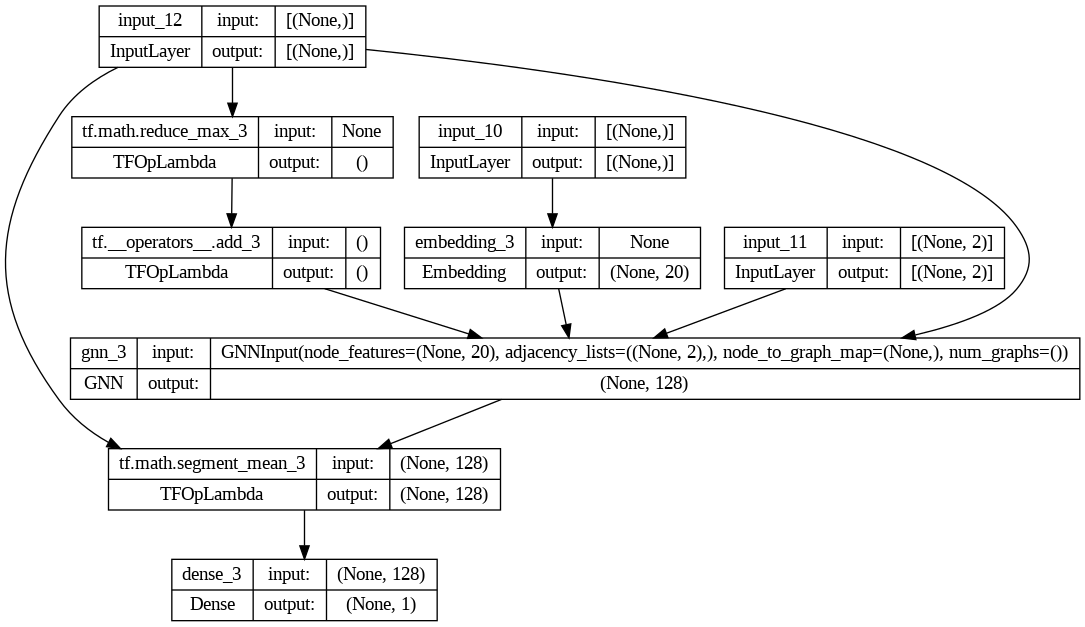

In [95]:
# This enables in-line display of the model plots in notebooks.
tf.keras.utils.plot_model(model, show_shapes=True)

In [96]:
# we will use Adam Optimizer.
model.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [97]:
%%time
import math

batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
num_batchs = math.ceil(len(training_set) / batch_size) #no. of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) #no. of batches for validation data

# fit our model with 20 epocks and different batch_size.
history = model.fit(
    # gen_batch for training data set
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=20,
    # gen_batch for validation data set
    validation_data=gen_batch(validation_set, batch_size=32, repeat=True),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5, restore_best_weights=True,mode='max')],
)

Epoch 1/20
665/665 [==============================] - 45s 53ms/step - loss: 0.2350 - auc: 0.5130 - val_loss: 0.1865 - val_auc: 0.6199
Epoch 2/20
665/665 [==============================] - 30s 46ms/step - loss: 0.1954 - auc: 0.6236 - val_loss: 0.1786 - val_auc: 0.6921
Epoch 3/20
665/665 [==============================] - 30s 46ms/step - loss: 0.1858 - auc: 0.6765 - val_loss: 0.1794 - val_auc: 0.6894
Epoch 4/20
665/665 [==============================] - 35s 52ms/step - loss: 0.1833 - auc: 0.6797 - val_loss: 0.1802 - val_auc: 0.7109
Epoch 5/20
665/665 [==============================] - 34s 51ms/step - loss: 0.1788 - auc: 0.7073 - val_loss: 0.1869 - val_auc: 0.7108
Epoch 6/20
665/665 [==============================] - 19s 28ms/step - loss: 0.1810 - auc: 0.7013 - val_loss: 0.1776 - val_auc: 0.7365
Epoch 7/20
665/665 [==============================] - 20s 30ms/step - loss: 0.1769 - auc: 0.7264 - val_loss: 0.1633 - val_auc: 0.7559
Epoch 8/20
665/665 [==============================] - 19s 28ms

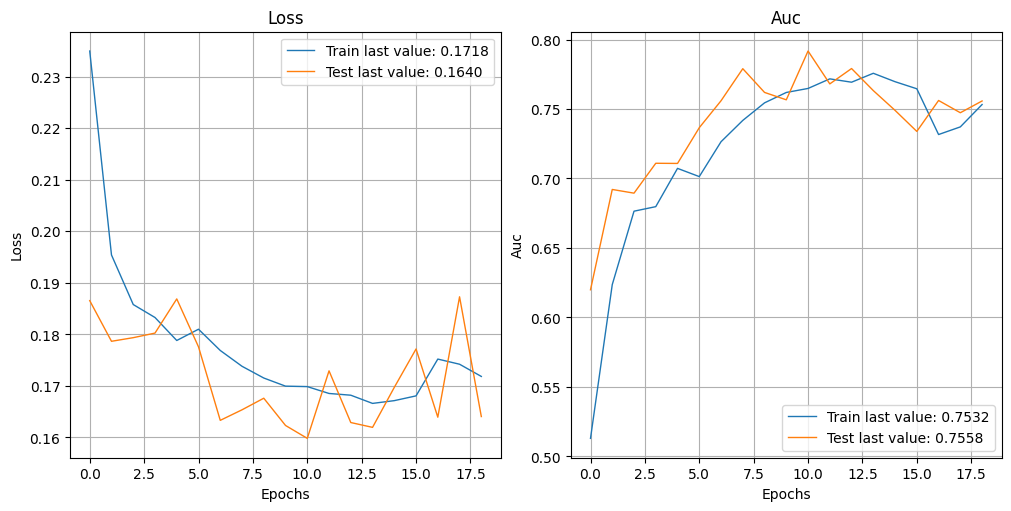

In [98]:
# just call this cell
Virt_fun(history)

In [99]:
# to predict our model
y_pred = model.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
# to reshape y_pred
y_pred = np.reshape(y_pred, -1)
y_pred.shape

771/771 [==============================] - 7s 8ms/step


(12326,)

In [100]:
y_pred

array([0.35778898, 0.17128488, 0.00303122, ..., 0.00705124, 0.00913718,
       0.02521981], dtype=float32)

In [101]:
import pandas as pd 
# create datafram with y_pred & id columns
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
# convert the dataframe to csv file
submission.to_csv('sample_submission_trial_3.csv')

In [102]:
from google.colab import files
# to download the csv file
files.download("sample_submission_trial_3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**observation:**

The model still overfitting because of unbalanced classes in the data
the scor in kaggle: 0.7789 bad score 

**Trial_4 with RGIN**

> GIN is one such example among many
maximally powerful GNNs, while being simple.

https://towardsdatascience.com/how-to-design-the-most-powerful-graph-neural-network-3d18b07a6e66

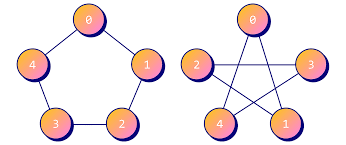




## Read SDF format data (structured-data format)

In [104]:
#importing libraries
import numpy as np   
# IPython/Jupyter Notebook progressbar decorator for iterators.
from tqdm.notebook import tqdm 

# fun. to read sdf file, the chemical composition of a molecule is saved as (structure data file)
def read_sdf(file):
    with open(file, 'r') as rf:   #opening the file
        content = rf.read()       #reading the contents of the file
    # Split the read file by delimiter $$$$ thus splitting each molecule in an array
    samples = content.split('$$$$') 
    
    #fun. to read each molecule configuration
    def parse_sample(s):
        lines = s.splitlines()    #splitting the text data to lines
        links = []                #empty array for links
        nodes = []                #empty array for nodes
        label = 0
        #loop over each line
        for l in lines:           
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            # for Atom block 
            if l.startswith('    '):   
                feature = l.split()
                #node feature (atom) as O,C etc.
                node = feature[3] 
                #appending nodes    
                nodes.append(node) 
            # bond block tells about connections between atoms   
            elif l.startswith(' '):   
                # splitting line
                lnk = l.split()       
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    #appending links
                    links.append((int(lnk[0])-1, int(lnk[1])-1,))
        return nodes, np.array(links), label #return nodes, links and label
    # parse_sample for each molecule
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]  

In [105]:
from sklearn.model_selection import train_test_split
#reading train.sdf file
training_set = read_sdf('/content/train (1).sdf')
#splitting the train data
training_set, validation_set = train_test_split(training_set, test_size=0.15,)

  0%|          | 0/25024 [00:00<?, ?it/s]

In [106]:
#reading test file
testing_set  = read_sdf('/content/test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

 Visualizing a Sample

In [107]:
# libraries for displaying network of molecule
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [108]:
# fun. to visualize the compound graph atoms are given as nodes the connections are defined as edges

def visualize(sample):
    G=nx.Graph() #initiating an instance of Graph
    nodes = sample[0] #atoms as nodes
    edges = sample[1] #connections as edges
    #create dictionary for labels of the nodes
    labeldict={} 
    #create array for each node color
    node_color=[] 
    for i,n in enumerate(nodes): #for each node in the sample
        G.add_node(i)   #adding node to the graph each node as (0,1,2..)
        labeldict[i]=n  #dictionary building with [key,value] as [0:'C']
        node_color.append(colors[hash(n)%len(colors)]) #color coding

    # a list of nodes for each edge by adding egde to the graph from one connection to other connection
    for e in edges:
        G.add_edge(e[0], e[1])

    #drawing the graph with labels for nodes as atoms and connections as edges    
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    #returns graph
    return G

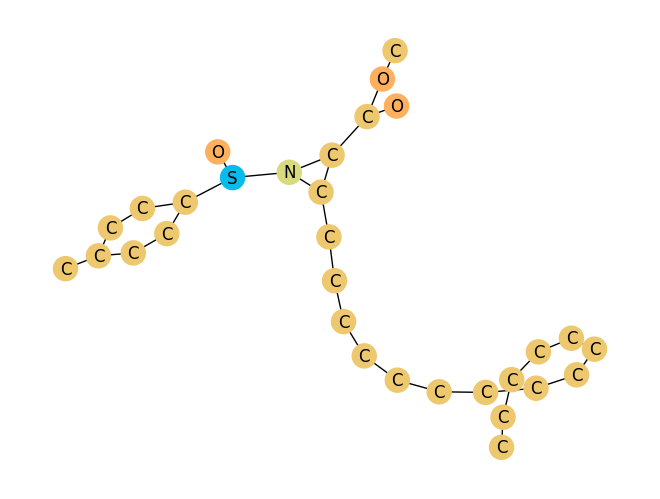

In [110]:
#displaying one sample
plt.clf()
visualize(training_set[10])

In [111]:
print('length of training_set:', len(training_set))
print('length of traiing_set[0]:', len(training_set[0]))
print('length of testing_set:', len(testing_set))
print('length of testing_set[0]:', len(testing_set[0]))

length of training_set: 21270
length of traiing_set[0]: 3
length of testing_set: 12326
length of testing_set[0]: 3


## Preprocessing
> * Tokenizing the nodes(atoms)
> * With Different vocabulary size

In [112]:
#Tokenizer importing 
from tensorflow.keras.preprocessing.text import Tokenizer

#vocabulary size
max_vocab = 400
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in training_set]
#training tokenizer
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [113]:
#importing libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
# random seed
random.seed(0) 


# fun. to prepare single batch set Samples represents the batch of data
def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples] # Nodes characters array
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)   # tokenizing the sample nodes
    sample_nodes = pad_sequences(sample_nodes, padding='post')  # pad_sequences for each sample node with post padding
    max_nodes_len = np.shape(sample_nodes)[1] #shape: (num of samples, number of nodes) 
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]  #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0] #make sure all elements are non-zero
    # definition for segmented_ids
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]  
    
    all_nodes = np.reshape(sample_nodes, -1)  #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)         #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    #returns a dictionary of features(data,edges,node2grah) and label
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples]) 


#generating batch with given btch_size
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:                 #infinity loop
        dataset = list(dataset) #data in the array
        if shuffle:             # if shuffle is True
            random.shuffle(dataset) #randomly shuffling
        l = len(dataset)  #length of dataset
        for ndx in range(0, l, batch_size):  #loop for  creating batches from given dataset
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] #creating batch samples with given batch_size
            yield prepare_single_batch(batch_samples)   #returning a generator with prepared batches
        if not repeat:  #breaking loop if repeat is false
            break

In [114]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=10):
    for k,v in train_batch[0].items(): #k: labels, v: values
        print(k)        
        print(v)
        print("Shape is "+str(np.shape(v)))
        pass
    print('label', train_batch[1])
    break

data
[ 5  2  2  2  3  3  3  3  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2
  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2  3
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6  6  6  6  2  2
  3  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  4  4  4  1  1  1  1
  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  2  2  3  3  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1 36  2  2  2  3 

In [115]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

#for deep Graph Neural Network
from tf2_gnn.layers.gnn import GNN, GNNInput

#GGNN, RGCN,RGAT, RGIN, GNN-Edge-MLP, GNN-FiLM
from  tf2_gnn.layers.message_passing import gnn_edge_mlp,gnn_film,rgat,rgin,rgcn,ggnn

In [116]:
#importing tensorflow and other libraries
import tensorflow as tf
from tensorflow.math import segment_mean # to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model # layers and model
from tensorflow.keras.layers import Embedding, Dense # layers
from tensorflow.keras.optimizers import Adam # optimizer


# The GNN layer takes a GNNInput named tuple as input, which encapsulates initial node features, adjacency lists, and auxiliary information.
#Input layer for nodes (tokenized text data) , eg. [440]
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input layer for edge data, eg. [257,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input layer for node2graph ids , eg. [440]
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding layer over data with each token embedded as  size vector eg. [440,50]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'rgin'
params["hidden_dim"] = 32 #defining hidden dimension of the gnn layer
params["num_aggr_MLP_hidden_layers"] = 1

#gnn layer with defined hyperparameters
gnn_layer = GNN(params)

#gnn output layer 
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

#final dense layer with sigmoid
pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

#building model inputs are data,edges and node2graph
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
#printing summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []        

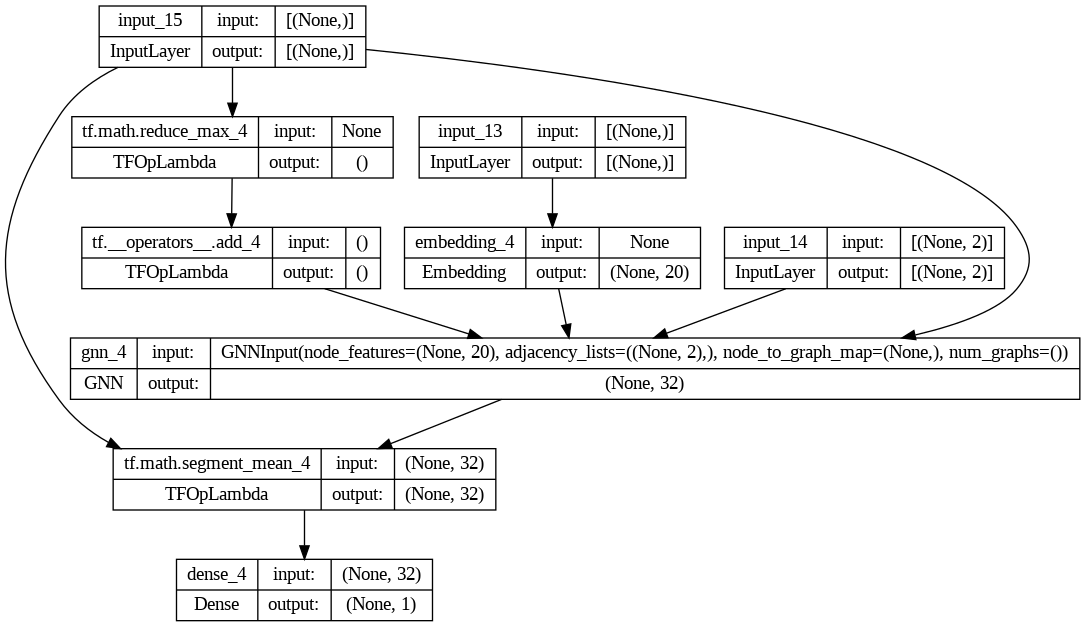

In [117]:
# This enables in-line display of the model plots in notebooks.
tf.keras.utils.plot_model(model, show_shapes=True)

In [118]:
# we will use Adam Optimizer.
model.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [119]:
%%time
import math

batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
num_batchs = math.ceil(len(training_set) / batch_size) #no. of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) #no. of batches for validation data

# fit our model with 20 epocks and different batch_size.
history = model.fit(
    # gen_batch for training data set
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=20,
    # gen_batch for validation data set
    validation_data=gen_batch(validation_set, batch_size=32, repeat=True),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5, restore_best_weights=True,mode='max')],
)

Epoch 1/20
665/665 [==============================] - 29s 33ms/step - loss: 0.2461 - auc: 0.5209 - val_loss: 0.1913 - val_auc: 0.6381
Epoch 2/20
665/665 [==============================] - 22s 34ms/step - loss: 0.1932 - auc: 0.6494 - val_loss: 0.1921 - val_auc: 0.6881
Epoch 3/20
665/665 [==============================] - 11s 17ms/step - loss: 0.1879 - auc: 0.6705 - val_loss: 0.1761 - val_auc: 0.7180
Epoch 4/20
665/665 [==============================] - 10s 16ms/step - loss: 0.1836 - auc: 0.6910 - val_loss: 0.1772 - val_auc: 0.7152
Epoch 5/20
665/665 [==============================] - 12s 18ms/step - loss: 0.1828 - auc: 0.6925 - val_loss: 0.1798 - val_auc: 0.7265
Epoch 6/20
665/665 [==============================] - 12s 18ms/step - loss: 0.1831 - auc: 0.6938 - val_loss: 0.1709 - val_auc: 0.7478
Epoch 7/20
665/665 [==============================] - 12s 18ms/step - loss: 0.1806 - auc: 0.7022 - val_loss: 0.1731 - val_auc: 0.7326
Epoch 8/20
665/665 [==============================] - 12s 17ms

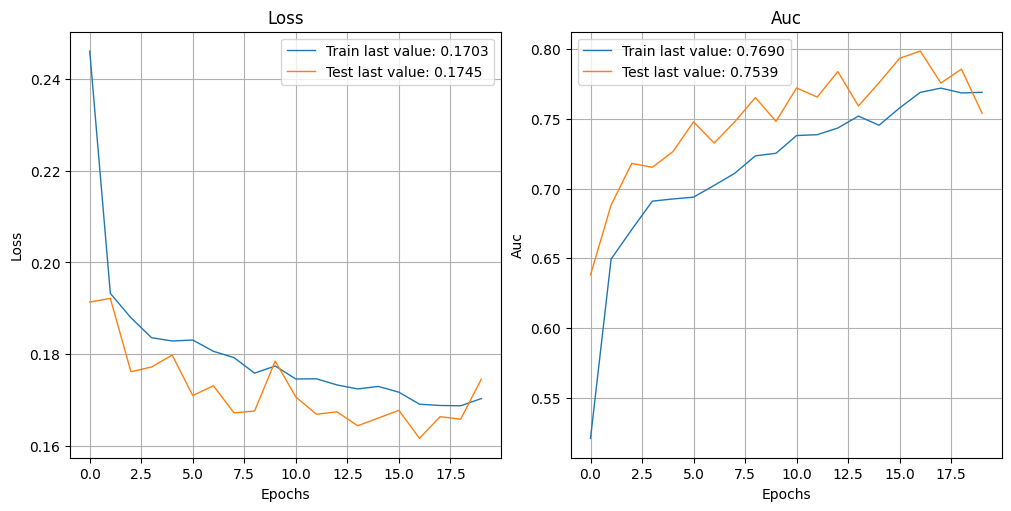

In [120]:
# just call this cell
Virt_fun(history)

In [121]:
# to predict our model
y_pred = model.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
# to reshape y_pred
y_pred = np.reshape(y_pred, -1)
y_pred.shape

771/771 [==============================] - 7s 8ms/step


(12326,)

In [122]:
y_pred

array([0.12213974, 0.11807883, 0.03164056, ..., 0.02792949, 0.06576211,
       0.04803417], dtype=float32)

In [123]:
import pandas as pd 
# create datafram with y_pred & id columns
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
# convert the dataframe to csv file
submission.to_csv('sample_submission_trial_4.csv')

In [124]:
from google.colab import files
# to download the csv file
files.download("sample_submission_trial_4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

observation:

The model still overfitting because of unbalanced classes in the data the score **in kaggle: 0.7868 bad score**

**Trial_5 with GNN_Edge_MLP**

> Graph Neural Network with Edge MLPs - a variant of RGCN in which messages on edges are computed using full MLPs, not just a single layer applied to the source state.

https://github.com/microsoft/tf-gnn-samples/blob/master/utils/model_utils.py






## Read SDF format data (structured-data format)

In [125]:
#importing libraries
import numpy as np   
# IPython/Jupyter Notebook progressbar decorator for iterators.
from tqdm.notebook import tqdm 

# fun. to read sdf file, the chemical composition of a molecule is saved as (structure data file)
def read_sdf(file):
    with open(file, 'r') as rf:   #opening the file
        content = rf.read()       #reading the contents of the file
    # Split the read file by delimiter $$$$ thus splitting each molecule in an array
    samples = content.split('$$$$') 
    
    #fun. to read each molecule configuration
    def parse_sample(s):
        lines = s.splitlines()    #splitting the text data to lines
        links = []                #empty array for links
        nodes = []                #empty array for nodes
        label = 0
        #loop over each line
        for l in lines:           
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            # for Atom block 
            if l.startswith('    '):   
                feature = l.split()
                #node feature (atom) as O,C etc.
                node = feature[3] 
                #appending nodes    
                nodes.append(node) 
            # bond block tells about connections between atoms   
            elif l.startswith(' '):   
                # splitting line
                lnk = l.split()       
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    #appending links
                    links.append((int(lnk[0])-1, int(lnk[1])-1,))
        return nodes, np.array(links), label #return nodes, links and label
    # parse_sample for each molecule
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]  

In [126]:
from sklearn.model_selection import train_test_split
#reading train.sdf file
training_set = read_sdf('/content/train (1).sdf')
#splitting the train data
training_set, validation_set = train_test_split(training_set, test_size=0.15,)

  0%|          | 0/25024 [00:00<?, ?it/s]

In [127]:
#reading test file
testing_set  = read_sdf('/content/test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

## Visualizing/Inspecting a Sample

In [128]:
# libraries for displaying network of molecule
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [129]:
# fun. to visualize the compound graph atoms are given as nodes the connections are defined as edges

def visualize(sample):
    G=nx.Graph() #initiating an instance of Graph
    nodes = sample[0] #atoms as nodes
    edges = sample[1] #connections as edges
    #create dictionary for labels of the nodes
    labeldict={} 
    #create array for each node color
    node_color=[] 
    for i,n in enumerate(nodes): #for each node in the sample
        G.add_node(i)   #adding node to the graph each node as (0,1,2..)
        labeldict[i]=n  #dictionary building with [key,value] as [0:'C']
        node_color.append(colors[hash(n)%len(colors)]) #color coding

    # a list of nodes for each edge by adding egde to the graph from one connection to other connection
    for e in edges:
        G.add_edge(e[0], e[1])

    #drawing the graph with labels for nodes as atoms and connections as edges    
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    #returns graph
    return G

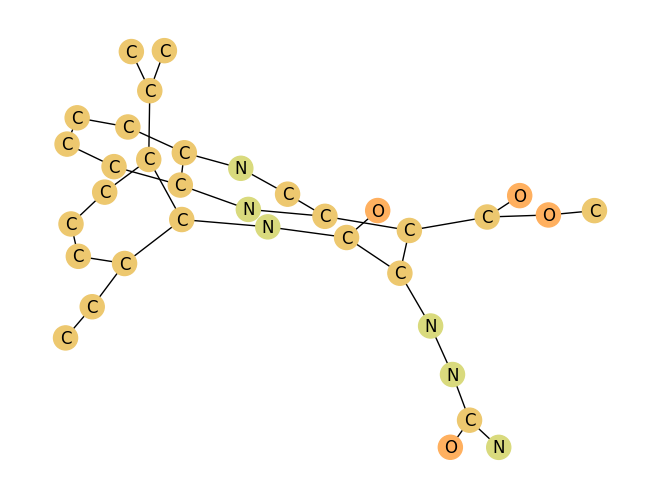

In [130]:
#displaying one sample
plt.clf()
visualize(training_set[1])

In [131]:
print('length of training_set:', len(training_set))
print('length of traiing_set[0]:', len(training_set[0]))
print('length of testing_set:', len(testing_set))
print('length of testing_set[0]:', len(testing_set[0]))

length of training_set: 21270
length of traiing_set[0]: 3
length of testing_set: 12326
length of testing_set[0]: 3


## Preprocessing
> * Tokenizing the nodes(atoms)
> * With Different vocabulary size

In [132]:
#Tokenizer importing 
from tensorflow.keras.preprocessing.text import Tokenizer

#vocabulary size
max_vocab = 400
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in training_set]
#training tokenizer
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [133]:
#importing libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
# random seed
random.seed(0) 


# fun. to prepare single batch set Samples represents the batch of data
def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples] # Nodes characters array
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)   # tokenizing the sample nodes
    sample_nodes = pad_sequences(sample_nodes, padding='post')  # pad_sequences for each sample node with post padding
    max_nodes_len = np.shape(sample_nodes)[1] #shape: (num of samples, number of nodes) 
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]  #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0] #make sure all elements are non-zero
    # definition for segmented_ids
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]  
    
    all_nodes = np.reshape(sample_nodes, -1)  #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)         #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    #returns a dictionary of features(data,edges,node2grah) and label
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples]) 


#generating batch with given btch_size
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:                 #infinity loop
        dataset = list(dataset) #data in the array
        if shuffle:             # if shuffle is True
            random.shuffle(dataset) #randomly shuffling
        l = len(dataset)  #length of dataset
        for ndx in range(0, l, batch_size):  #loop for  creating batches from given dataset
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] #creating batch samples with given batch_size
            yield prepare_single_batch(batch_samples)   #returning a generator with prepared batches
        if not repeat:  #breaking loop if repeat is false
            break

In [134]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=10):
    for k,v in train_batch[0].items(): #k: labels, v: values
        print(k)        
        print(v)
        print("Shape is "+str(np.shape(v)))
        pass
    print('label', train_batch[1])
    break

data
[24  5  5  5  2  2  2  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  7  2  2  3  3  1
  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  3  3  3  3  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  5  5  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  4  2  2
  3  3  3  3  3  3  3  3  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 11  2  2  3  3  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0
  0  0  0  0  0  0  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
  2  3  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0 

In [135]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

#for deep Graph Neural Network
from tf2_gnn.layers.gnn import GNN, GNNInput

#GGNN, RGCN,RGAT, RGIN, GNN-Edge-MLP, GNN-FiLM
from  tf2_gnn.layers.message_passing import gnn_edge_mlp,gnn_film,rgat,rgin,rgcn,ggnn

In [136]:
#importing tensorflow and other libraries
import tensorflow as tf
from tensorflow.math import segment_mean # to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model # layers and model
from tensorflow.keras.layers import Embedding, Dense # layers
from tensorflow.keras.optimizers import Adam # optimizer


# The GNN layer takes a GNNInput named tuple as input, which encapsulates initial node features, adjacency lists, and auxiliary information.
#Input layer for nodes (tokenized text data) , eg. [440]
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input layer for edge data, eg. [257,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input layer for node2graph ids , eg. [440]
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding layer over data with each token embedded as  size vector eg. [440,50]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'GNN_Edge_MLP'
params["hidden_dim"] = 32 #defining hidden dimension of the gnn layer


#gnn layer with defined hyperparameters
gnn_layer = GNN(params)

#gnn output layer 
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

#final dense layer with sigmoid
pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

#building model inputs are data,edges and node2graph
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
#printing summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []        

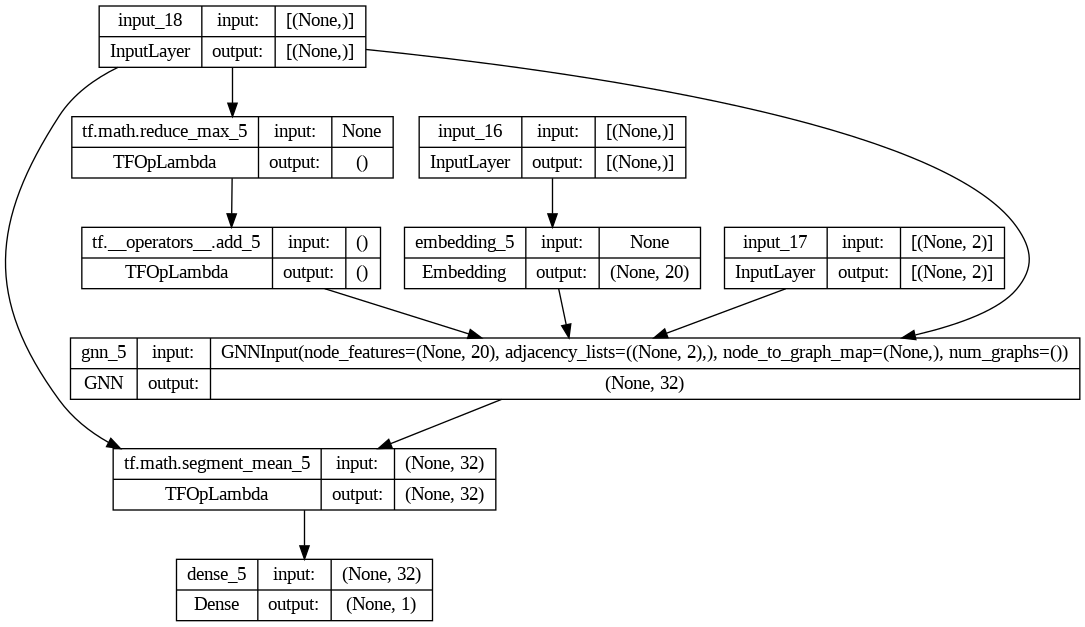

In [137]:
# This enables in-line display of the model plots in notebooks.
tf.keras.utils.plot_model(model, show_shapes=True)

In [138]:
# we will use Adam Optimizer.
model.compile(
    optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [139]:
%%time
import math

batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
num_batchs = math.ceil(len(training_set) / batch_size) #no. of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) #no. of batches for validation data

# fit our model with 20 epocks and different batch_size.
history=model.fit(
    # gen_batch for training data set
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=20,
    # gen_batch for validation data set
    validation_data=gen_batch(validation_set, batch_size=32, repeat=True),
    validation_steps=num_batchs_validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5, restore_best_weights=True,mode='max')],
)

Epoch 1/20
665/665 [==============================] - 19s 22ms/step - loss: 0.2588 - auc: 0.4562 - val_loss: 0.1902 - val_auc: 0.6318
Epoch 2/20
665/665 [==============================] - 19s 29ms/step - loss: 0.1945 - auc: 0.5997 - val_loss: 0.1820 - val_auc: 0.6575
Epoch 3/20
665/665 [==============================] - 17s 25ms/step - loss: 0.1869 - auc: 0.6525 - val_loss: 0.1762 - val_auc: 0.6900
Epoch 4/20
665/665 [==============================] - 10s 15ms/step - loss: 0.1845 - auc: 0.6757 - val_loss: 0.1819 - val_auc: 0.6838
Epoch 5/20
665/665 [==============================] - 11s 16ms/step - loss: 0.1825 - auc: 0.6896 - val_loss: 0.1890 - val_auc: 0.6701
Epoch 6/20
665/665 [==============================] - 10s 16ms/step - loss: 0.1803 - auc: 0.7013 - val_loss: 0.1737 - val_auc: 0.7055
Epoch 7/20
665/665 [==============================] - 10s 15ms/step - loss: 0.1798 - auc: 0.7075 - val_loss: 0.1893 - val_auc: 0.6903
Epoch 8/20
665/665 [==============================] - 10s 16ms

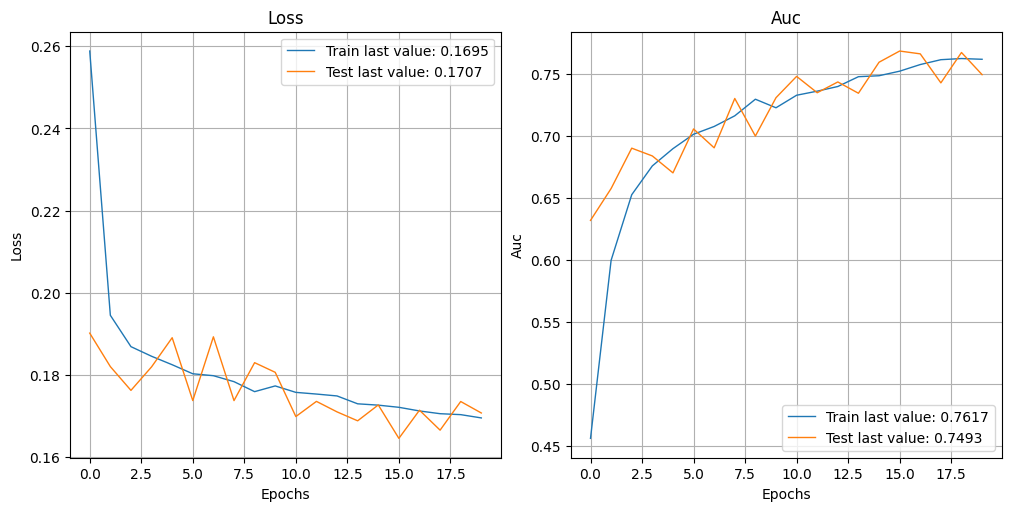

In [140]:
# just call this cell
Virt_fun(history)

In [141]:
# to predict our model
y_pred = model.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
# to reshape y_pred
y_pred = np.reshape(y_pred, -1)
y_pred.shape

771/771 [==============================] - 4s 5ms/step


(12326,)

In [142]:
y_pred

array([0.21635292, 0.12181254, 0.06182411, ..., 0.01096387, 0.18837498,
       0.03046297], dtype=float32)

**observation:**

The model still overfitting because of unbalanced classes in the data the score

in kaggle: 0.7849 bad score

so from previous trials all the models suffer from overfitting so lets try another data prprocessing and see  What will happen

In [143]:
import pandas as pd 
# create datafram with y_pred & id columns
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
# convert the dataframe to csv file
submission.to_csv('sample_submission_trial_5.csv')

In [144]:
from google.colab import files
# to download the csv file
files.download("sample_submission_trial_5.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Data Preprocessing trial 2 with Upsampling.**


** Resample dataset to have balanced classes AS we have in almost of the previous trials overfitting because of the data unbalanced class**

after resample we will see if the data will give us better Auc or not

## Read SDF format data (structured-data format)

In [162]:
#importing libraries
import numpy as np   
# IPython/Jupyter Notebook progressbar decorator for iterators.
from tqdm.notebook import tqdm 

# fun. to read sdf file, the chemical composition of a molecule is saved as (structure data file)
def read_sdf(file):
    with open(file, 'r') as rf:   #opening the file
        content = rf.read()       #reading the contents of the file
    # Split the read file by delimiter $$$$ thus splitting each molecule in an array
    samples = content.split('$$$$') 
    
    #fun. to read each molecule configuration
    def parse_sample(s):
        lines = s.splitlines()    #splitting the text data to lines
        links = []                #empty array for links
        nodes = []                #empty array for nodes
        label = 0
        #loop over each line
        for l in lines:           
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            # for Atom block 
            if l.startswith('    '):   
                feature = l.split()
                #node feature (atom) as O,C etc.
                node = feature[3] 
                #appending nodes    
                nodes.append(node) 
            # bond block tells about connections between atoms   
            elif l.startswith(' '):   
                # splitting line
                lnk = l.split()       
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    #appending links
                    links.append((int(lnk[0])-1, int(lnk[1])-1,))
        return nodes, np.array(links), label #return nodes, links and label
    # parse_sample for each molecule
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]  

In [163]:
from sklearn.model_selection import train_test_split
#reading train.sdf file
training_set = read_sdf('/content/train (1).sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

In [164]:
#reading test file
testing_set  = read_sdf('/content/test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

> Split the data into random train and test subsets.

> Note : Because we don't know if test data will be balanced or not , the oversample only on training dataset.

> If we balance the validation set our model may work well (may get better score in Val) but in the future after deploying, it may not work better so while training, validate with imbalance data only.

In [165]:
#splitting the train data
training_set, validation_set = train_test_split(training_set, test_size=0.15,)

Imbalanced data

In [166]:
np.unique(np.array(training_set)[:,2],return_counts=True)

<ipython-input-166-e284c3aa5333>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.unique(np.array(training_set)[:,2],return_counts=True)


(array([0, 1], dtype=object), array([20219,  1051]))

<ipython-input-167-0d61248110e3>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sns.countplot(np.array(training_set)[:,2])


<Axes: ylabel='count'>

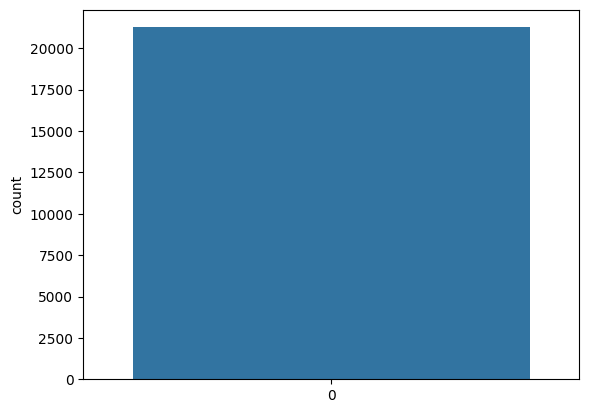

In [167]:
#"sns" is the standard alias.
import seaborn as sns
sns.countplot(np.array(training_set)[:,2])

In [168]:
import pandas as pd

In [169]:
X_train = pd.DataFrame(np.array(training_set)[:,:-1])
y_train = pd.DataFrame(np.array(training_set)[:,2])

<ipython-input-169-44f583a9593f>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = pd.DataFrame(np.array(training_set)[:,:-1])
<ipython-input-169-44f583a9593f>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train = pd.DataFrame(np.array(training_set)[:,2])


In [170]:
from sklearn.utils import resample
def resamplingDataPrep(X_train, y_train, target_var): 
    
    # concatenate our training data back together
    resampling = X_train.copy()
    resampling[target_var] = y_train.values
    
    # separate minority and majority classes
    majority_class = resampling[resampling[target_var]==0]
    minority_class = resampling[resampling[target_var]==1]
    
    # Get a class count to understand the class imbalance.
    print('majority_class: '+ str(len(majority_class)))
    print('minority_class: '+ str(len(minority_class)))
    
    # sample with replacement to match majority class reproducible results
    minority_class_after = resample(minority_class, replace=True,n_samples=20237,random_state=42)
    print('minority_class_after: '+ str(len(minority_class_after)))
    return majority_class, minority_class_after

# call resamplingDataPrep fun.
z1,z2 = resamplingDataPrep(X_train,y_train,2)

majority_class: 20219
minority_class: 1051
minority_class_after: 20237


In [171]:
# To make sure everything is alright
z2

,0,1,2
17342,"[Cu, Cl, Cl, N, N, N, N, C, C, C, C, C, C, C, ...","[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [3, 6...",1
21113,"[O, O, O, O, O, N, N, N, C, C, C, C, C, C, C, ...","[[0, 13], [1, 15], [2, 27], [2, 28], [3, 34], ...",1
2187,"[S, N, N, N, N, C, C, C, C, C, C, C, C, C, C, ...","[[0, 7], [1, 7], [1, 8], [1, 9], [2, 3], [2, 7...",1
9821,"[N, N, N, N, C, C, C, C, C, C, C, C, C, C, C, ...","[[0, 6], [0, 7], [1, 4], [1, 8], [2, 14], [3, ...",1
6388,"[Cl, O, O, N, N, N, N, C, C, C, C, C, C, C, C,...","[[0, 20], [1, 8], [1, 10], [2, 9], [3, 4], [3,...",1
...,...,...,...
12834,"[Cl, O, O, O, N, N, N, N, C, C, C, C, C, C, C,...","[[0, 25], [1, 10], [2, 23], [2, 26], [3, 28], ...",1
8741,"[S, N, N, N, N, N, N, N, C, C, C, C, C, C, C, ...","[[0, 9], [1, 8], [1, 10], [1, 11], [2, 9], [2,...",1
17854,"[O, O, N, N, N, C, C, C, C, C, C, C, C, C, C, ...","[[0, 11], [1, 19], [1, 23], [2, 6], [2, 13], [...",1
8884,"[Cl, O, O, O, O, N, N, N, C, C, C, C, C, C, C,...","[[0, 27], [1, 12], [2, 20], [2, 32], [3, 22], ...",1


In [172]:
z1

,0,1,2
0,"[O, O, O, O, O, C, C, C, C, C, C, C, C, C, C, ...","[[0, 5], [0, 6], [1, 9], [1, 16], [2, 12], [2,...",0
1,"[O, O, O, O, O, N, C, C, C, C, C, C, C, C, C, ...","[[0, 6], [0, 17], [1, 7], [1, 18], [2, 14], [3...",0
2,"[Si, N, N, C, C, C, C, C, C, C, C, C, C, C, C,...","[[0, 15], [0, 18], [0, 19], [0, 20], [1, 4], [...",0
3,"[O, O, O, O, O, O, O, O, C, C, C, C, C, C, C, ...","[[0, 8], [0, 9], [1, 14], [1, 28], [2, 15], [2...",0
5,"[S, O, O, O, N, N, N, C, C, C, C, C, C, C, C, ...","[[0, 8], [0, 10], [1, 9], [1, 14], [2, 9], [3,...",0
...,...,...,...
21264,"[O, O, N, N, C, C, C, C, C, C, C, C, C, C, C, ...","[[0, 5], [0, 6], [1, 11], [2, 4], [2, 8], [2, ...",0
21265,"[Cl, Cl, O, O, N, C, C, C, C, C, C, C, C, C, C...","[[0, 14], [1, 15], [2, 18], [3, 18], [4, 5], [...",0
21266,"[O, O, C, C, C, C, C, C, C, C, C, C, C, C, C, ...","[[0, 10], [1, 11], [2, 4], [2, 8], [2, 16], [2...",0
21268,"[S, S, O, O, O, O, O, C, C, C, C, C, C, C, C, ...","[[0, 10], [0, 22], [1, 10], [1, 23], [2, 11], ...",0


In [173]:
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([z1, z2])

In [174]:
# Display new class counts
df_upsampled[2].value_counts()

1    20237
0    20219
Name: 2, dtype: int64

<Axes: ylabel='count'>

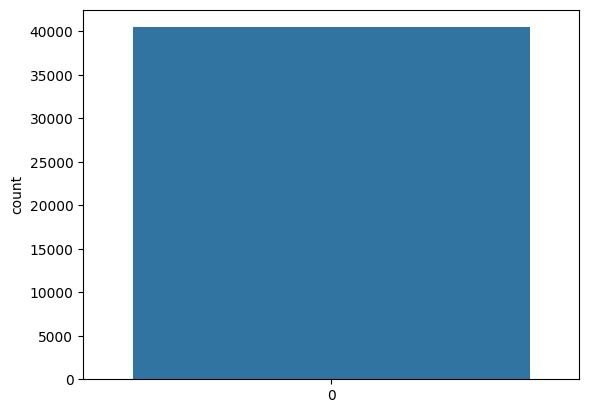

In [177]:
# To make sure everything is alright.
sns.countplot(df_upsampled[2])

In [178]:
# convert our dataFrame to list
training_set = df_upsampled.values.tolist()

## Visualizing/Inspecting a Sample

In [179]:
# libraries for displaying network of molecule
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [180]:
# fun. to visualize the compound graph atoms are given as nodes the connections are defined as edges

def visualize(sample):
    G=nx.Graph() #initiating an instance of Graph
    nodes = sample[0] #atoms as nodes
    edges = sample[1] #connections as edges
    #create dictionary for labels of the nodes
    labeldict={} 
    #create array for each node color
    node_color=[] 
    for i,n in enumerate(nodes): #for each node in the sample
        G.add_node(i)   #adding node to the graph each node as (0,1,2..)
        labeldict[i]=n  #dictionary building with [key,value] as [0:'C']
        node_color.append(colors[hash(n)%len(colors)]) #color coding

    # a list of nodes for each edge by adding egde to the graph from one connection to other connection
    for e in edges:
        G.add_edge(e[0], e[1])

    #drawing the graph with labels for nodes as atoms and connections as edges    
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    #returns graph
    return G

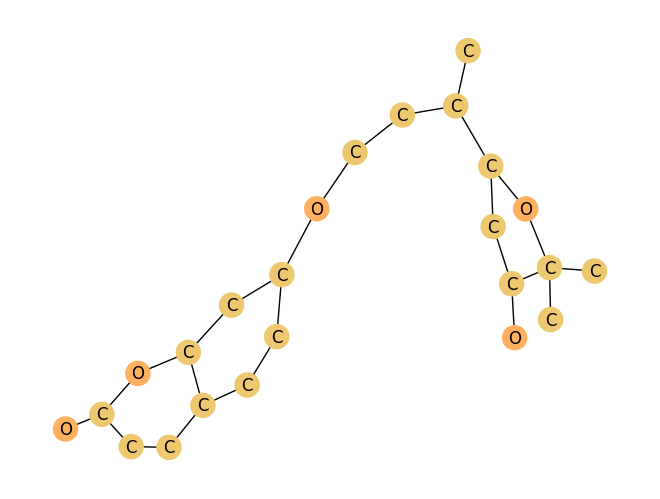

In [181]:
#displaying one sample
plt.clf()
visualize(training_set[0])

In [182]:
print('length of training_set:', len(training_set))
print('length of traiing_set[0]:', len(training_set[0]))
print('length of testing_set:', len(testing_set))
print('length of testing_set[0]:', len(testing_set[0]))

length of training_set: 40456
length of traiing_set[0]: 3
length of testing_set: 12326
length of testing_set[0]: 3


## Preprocessing
> * Tokenizing the nodes(atoms)
> * With Different vocabulary size

In [183]:
#Tokenizer importing 
from tensorflow.keras.preprocessing.text import Tokenizer

#vocabulary size
max_vocab = 400
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in training_set]
#training tokenizer
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [184]:
#importing libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
# random seed
random.seed(0) 


# fun. to prepare single batch set Samples represents the batch of data
def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples] # Nodes characters array
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)   # tokenizing the sample nodes
    sample_nodes = pad_sequences(sample_nodes, padding='post')  # pad_sequences for each sample node with post padding
    max_nodes_len = np.shape(sample_nodes)[1] #shape: (num of samples, number of nodes) 
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]  #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0] #make sure all elements are non-zero
    # definition for segmented_ids
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]  
    
    all_nodes = np.reshape(sample_nodes, -1)  #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)         #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    #returns a dictionary of features(data,edges,node2grah) and label
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples]) 


#generating batch with given btch_size
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:                 #infinity loop
        dataset = list(dataset) #data in the array
        if shuffle:             # if shuffle is True
            random.shuffle(dataset) #randomly shuffling
        l = len(dataset)  #length of dataset
        for ndx in range(0, l, batch_size):  #loop for  creating batches from given dataset
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] #creating batch samples with given batch_size
            yield prepare_single_batch(batch_samples)   #returning a generator with prepared batches
        if not repeat:  #breaking loop if repeat is false
            break

In [185]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=10):
    for k,v in train_batch[0].items(): #k: labels, v: values
        print(k)        
        print(v)
        print("Shape is "+str(np.shape(v)))
        pass
    print('label', train_batch[1])
    break

data
[5 2 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 3 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 5 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 4 3 3 3 3 3 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 3 3 3 3
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 4 2 2 2 2 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0

In [186]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

#for deep Graph Neural Network
from tf2_gnn.layers.gnn import GNN, GNNInput

In [187]:
#importing tensorflow and other libraries
import tensorflow as tf
from tensorflow.math import segment_mean # to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model # layers and model
from tensorflow.keras.layers import Embedding, Dense # layers
from tensorflow.keras.optimizers import Adam # optimizer


In [191]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

def trainModel(model_name,trial_no):
  # The GNN layer takes a GNNInput named tuple as input, which encapsulates initial node features, adjacency lists, and auxiliary information.
  #Input layer for nodes (tokenized text data) , eg. [440]
  data = keras.Input(batch_shape=(None,))

  # the first dim is different to the previous one. it is the total number of edges in this batch
  edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input layer for edge data, eg. [257,2]
  node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input layer for node2graph ids , eg. [440]
  embeded = Embedding(tokenizer.num_words, 20)(data) #embedding layer over data with each token embedded as  size vector eg. [440,50]

  # number of graphs (number of samples)
  num_graph = tf.reduce_max(node2graph)+1

  #gnn_input layer with inputs as defined above
  gnn_input = GNNInput(
      node_features=embeded,
      adjacency_lists=(edge,),
      node_to_graph_map=node2graph, 
      num_graphs=num_graph,
  )

  # https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
  params = GNN.get_default_hyperparameters()
  params["message_calculation_class"] = model_name
  params["hidden_dim"] = 128 #defining hidden dimension of the gnn layer
  params["num_layers"] = 8
  params["dense_every_num_layers"] = 8
  params["num_heads"] = 4
  params["num_aggr_MLP_hidden_layers"] = 1
  params["film_parameter_MLP_hidden_layers"] = 1

  #gnn layer with defined hyperparameters
  gnn_layer = GNN(params)

  #gnn output layer 
  gnn_out = gnn_layer(gnn_input)

  print('gnn_out', gnn_out)

  # https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
  avg = segment_mean(
      data=gnn_out,
      segment_ids=node2graph
  )
  print('mean:', avg)

  #final dense layer with sigmoid
  pred = Dense(1, activation='sigmoid')(avg)# binary classification: Dense(2), but here we only output 1 probability
  print('pred:', pred)

  #building model inputs are data,edges and node2graph
  #output: prediction value from dense layer
  model = Model(inputs={'data': data,'edges': edge,'node2grah': node2graph,},outputs=pred)

  # we will use Adam Optimizer.
  model.compile(optimizer = 'adam', loss='BinaryCrossentropy', metrics=['AUC'])

  import math

  batch_size = 32
  #math.ceil: returns the smallest integral value greater than the number
  num_batchs = math.ceil(len(training_set) / batch_size) #no. of batches for training data
  num_batchs_validation = math.ceil(len(validation_set) / batch_size) #no. of batches for validation data

  # fit our model with 20 epocks and different batch_size.
  history = model.fit(
      # gen_batch for training data set
      gen_batch(training_set, batch_size=batch_size, repeat=True),
      steps_per_epoch=num_batchs,
      epochs=15,
      # gen_batch for validation data set
      validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
      validation_steps=num_batchs_validation,
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5, restore_best_weights=True,mode='max')],)
  
  # show the history of our model
  show_history(history)
  plot_history(history, path="standard.png")
  plt.close()


  # to predict our model
  y_pred = model.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
  # to reshape y_pred
  y_pred = np.reshape(y_pred, -1)
  print(y_pred)

  import pandas as pd 
  # create datafram with y_pred & id columns
  submission = pd.DataFrame({'label':y_pred})
  submission.index.name = 'id'
  # convert the dataframe to csv file
  submission.to_csv('sample_submission_trial_'+trial_no+'.csv')


**Trial_6 with GGNN**





gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_7/StatefulPartitionedCall:0', description="created by layer 'gnn_7'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_7/SegmentMean:0', description="created by layer 'tf.math.segment_mean_7'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_7/Sigmoid:0', description="created by layer 'dense_7'")
Epoch 1/15
1265/1265 [==============================] - 80s 41ms/step - loss: 0.6211 - auc: 0.7113 - val_loss: 0.7525 - val_auc: 0.6520
Epoch 2/15
1265/1265 [==============================] - 45s 35ms/step - loss: 0.5613 - auc: 0.7820 - val_loss: 0.5851 - val_auc: 0.7724
Epoch 3/15
1265/1265 [==============================] - 45s 35ms/step - loss: 0.4901 - auc: 0.8438 - val_loss: 0.5086 - val_auc: 0.8081
Epoch 4/15
1265/1265 [==============================] - 44s 35ms/step - loss: 

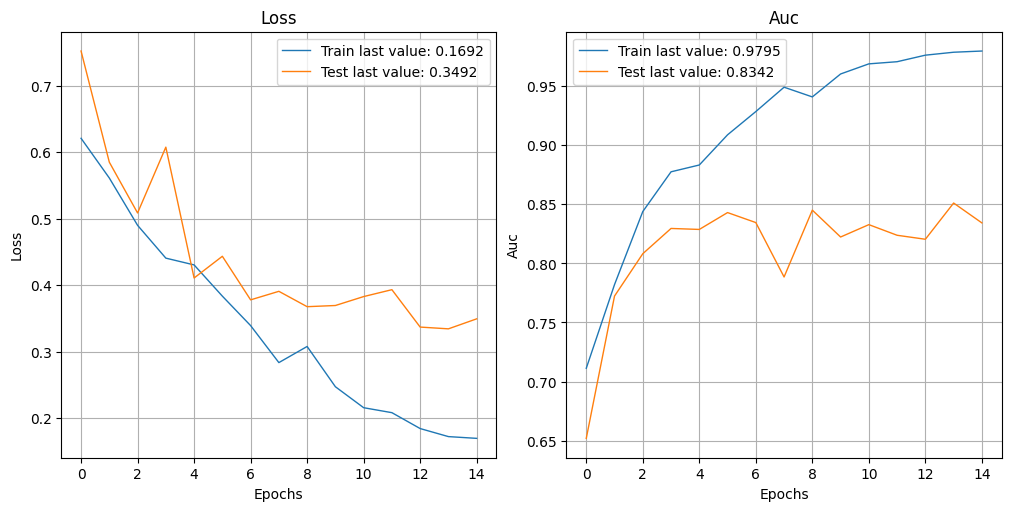

771/771 [==============================] - 7s 7ms/step
[9.9918097e-01 3.1662523e-04 3.4606917e-05 ... 1.9747446e-07 6.0172350e-04
 9.5667654e-01]
CPU times: user 13min 18s, sys: 40.2 s, total: 13min 58s
Wall time: 11min 57s


In [192]:
%%time
# just run this cell
trainModel('GGNN','6')


**After resampling GGNN model give me a score in kaggle 0.84133**

the score get better than th score we have when the data was without resample 

In [190]:
from google.colab import files
# to download the csv file
files.download("sample_submission_trial_6.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Trial_7 with RGAT**





gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_8/StatefulPartitionedCall:0', description="created by layer 'gnn_8'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_8/SegmentMean:0', description="created by layer 'tf.math.segment_mean_8'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_8/Sigmoid:0', description="created by layer 'dense_8'")
Epoch 1/15
1265/1265 [==============================] - 85s 56ms/step - loss: 0.6188 - auc: 0.7129 - val_loss: 0.6883 - val_auc: 0.7636
Epoch 2/15
1265/1265 [==============================] - 67s 53ms/step - loss: 0.5552 - auc: 0.7880 - val_loss: 0.6037 - val_auc: 0.7806
Epoch 3/15
1265/1265 [==============================] - 66s 53ms/step - loss: 0.5288 - auc: 0.8133 - val_loss: 0.6478 - val_auc: 0.7609
Epoch 4/15
1265/1265 [==============================] - 67s 53ms/step - loss: 

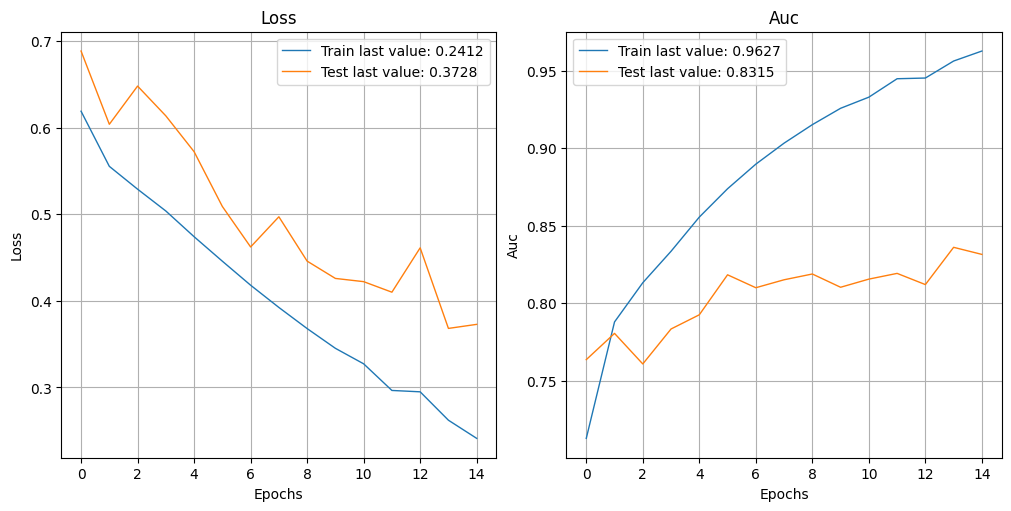

771/771 [==============================] - 9s 11ms/step
[9.8215401e-01 5.6780294e-02 1.3178970e-07 ... 2.0333293e-03 1.7835932e-03
 5.9455353e-01]
CPU times: user 20min 46s, sys: 1min 19s, total: 22min 6s
Wall time: 17min 26s


In [193]:
%%time
# just run this cell
trainModel('rgat','7')

**After resampling  RGAT model give me a score in kaggle 0.83181**

the score get better than th score we have when the data was without resample

In [243]:
from google.colab import files
# to download the csv file
files.download("sample_submission_trial_7.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Trial_8 with RGCN**





gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_9/StatefulPartitionedCall:0', description="created by layer 'gnn_9'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_9/SegmentMean:0', description="created by layer 'tf.math.segment_mean_9'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_9/Sigmoid:0', description="created by layer 'dense_9'")
Epoch 1/15
1265/1265 [==============================] - 85s 53ms/step - loss: 0.6343 - auc: 0.6848 - val_loss: 0.6386 - val_auc: 0.7045
Epoch 2/15
1265/1265 [==============================] - 52s 41ms/step - loss: 0.5900 - auc: 0.7484 - val_loss: 0.5821 - val_auc: 0.7606
Epoch 3/15
1265/1265 [==============================] - 48s 38ms/step - loss: 0.5629 - auc: 0.7808 - val_loss: 0.7062 - val_auc: 0.7584
Epoch 4/15
1265/1265 [==============================] - 39s 31ms/step - loss: 

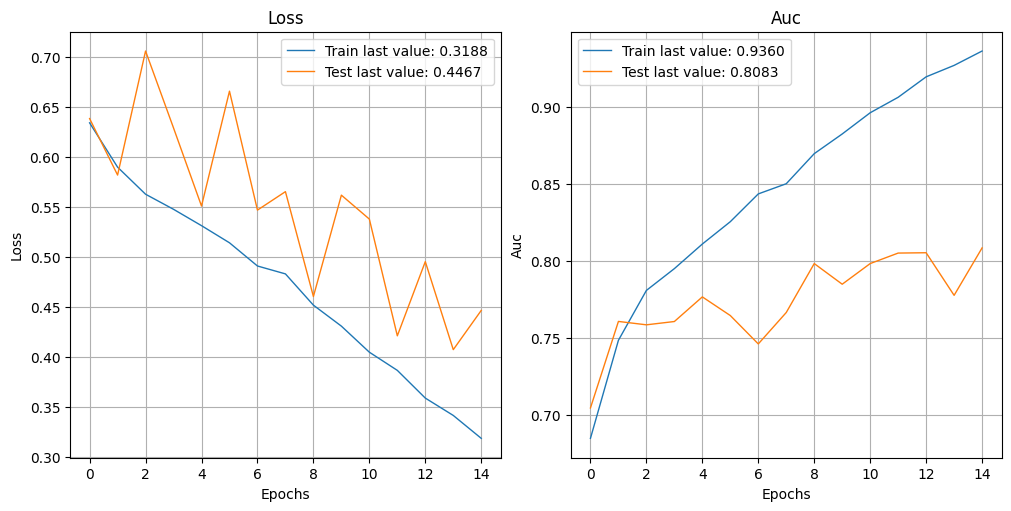

771/771 [==============================] - 6s 7ms/step
[9.2283225e-01 2.0868834e-02 4.7367898e-06 ... 2.5653346e-02 5.2706691e-06
 9.9759859e-01]
CPU times: user 11min 17s, sys: 37.2 s, total: 11min 54s
Wall time: 10min 26s


In [194]:
%%time
# just run this cell
trainModel('rgcn','8')

In [244]:
from google.colab import files
# to download the csv file
files.download("sample_submission_trial_8.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

After resampling RGCN model give me a score in kaggle 0.80551

the score get better than th score we have when the data was without resample

**Trial_9 with RGIN**





gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_10/StatefulPartitionedCall:0', description="created by layer 'gnn_10'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_10/SegmentMean:0', description="created by layer 'tf.math.segment_mean_10'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_10/Sigmoid:0', description="created by layer 'dense_10'")
Epoch 1/15
1265/1265 [==============================] - 59s 37ms/step - loss: 0.6455 - auc: 0.6769 - val_loss: 0.6712 - val_auc: 0.6853
Epoch 2/15
1265/1265 [==============================] - 43s 34ms/step - loss: 0.6078 - auc: 0.7286 - val_loss: 0.7383 - val_auc: 0.7055
Epoch 3/15
1265/1265 [==============================] - 41s 32ms/step - loss: 0.5949 - auc: 0.7448 - val_loss: 0.7269 - val_auc: 0.7234
Epoch 4/15
1265/1265 [==============================] - 41s 33ms/step - 

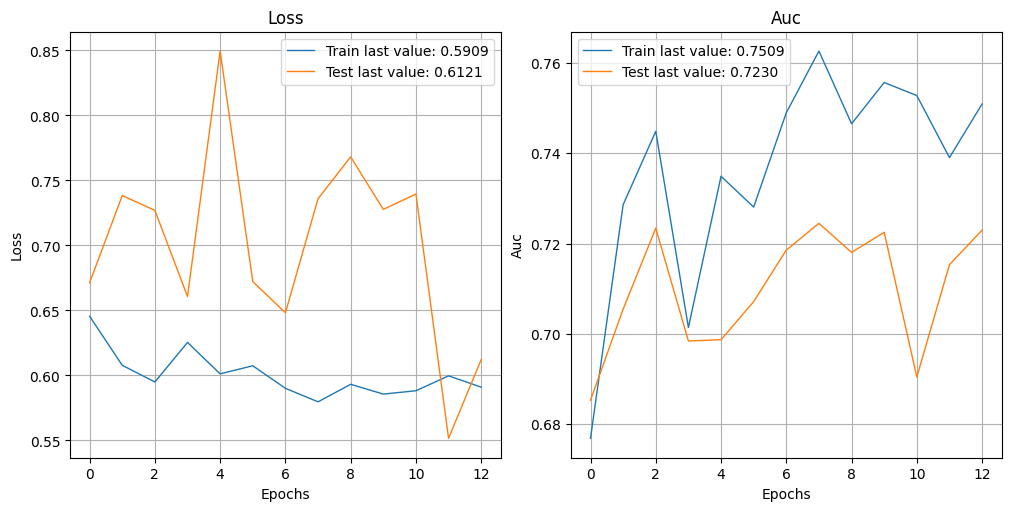

771/771 [==============================] - 7s 8ms/step
[0.7930601  0.681661   0.5279654  ... 0.26031902 0.895125   0.3246896 ]
CPU times: user 10min 52s, sys: 36 s, total: 11min 28s
Wall time: 9min 40s


In [195]:
%%time
# just run this cell
trainModel('rgin','9')

In [245]:
from google.colab import files
# to download the csv file
files.download("sample_submission_trial_9.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**observation**

After resampling RGIN model give me a score in kaggle 0.75222


**Trial_10 with GNN_Edge_MLP**





gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_11/StatefulPartitionedCall:0', description="created by layer 'gnn_11'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_11/SegmentMean:0', description="created by layer 'tf.math.segment_mean_11'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_11/Sigmoid:0', description="created by layer 'dense_11'")
Epoch 1/15
1265/1265 [==============================] - 54s 35ms/step - loss: 0.6281 - auc: 0.6960 - val_loss: 0.6918 - val_auc: 0.7251
Epoch 2/15
1265/1265 [==============================] - 40s 32ms/step - loss: 0.5807 - auc: 0.7611 - val_loss: 0.6693 - val_auc: 0.7362
Epoch 3/15
1265/1265 [==============================] - 38s 30ms/step - loss: 0.5498 - auc: 0.7939 - val_loss: 0.6076 - val_auc: 0.7514
Epoch 4/15
1265/1265 [==============================] - 35s 28ms/step - 

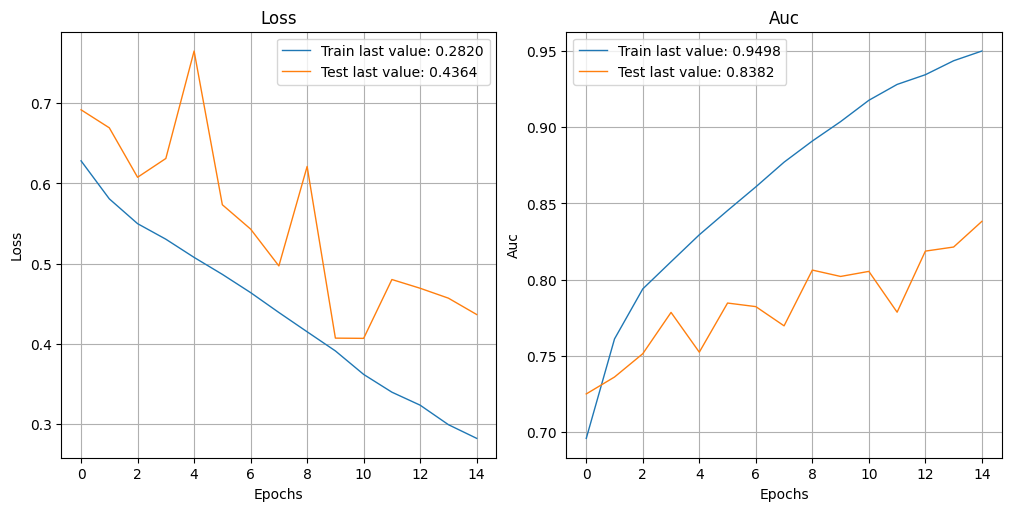

771/771 [==============================] - 6s 7ms/step
[9.3765712e-01 1.1847594e-01 2.7138143e-04 ... 2.4106449e-03 8.5947659e-06
 2.0563203e-01]
CPU times: user 11min 2s, sys: 37.3 s, total: 11min 39s
Wall time: 10min 41s


In [196]:
%%time
# just run this cell
trainModel('GNN_Edge_MLP','10')

In [246]:
from google.colab import files
# to download the csv file
files.download("sample_submission_trial_10.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**observation**

After resampling  model GNN_Edge_MLP give me a score in kaggle 0.80306

**After resasampling**\

i choose the model that give me best Auc and score in kaggle and try to do

different prprocessing and mke upsampling method to data classes   to use for

only this model and try to train the model outside the scope of the train

  function may the score would be better and after this cell are  the cells that implement upsampling and preprocesing in data for the GGNN model

In [206]:
#reading train.sdf file
training_set_T2 = read_sdf('/content/train (1).sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

In [207]:
#checking for data balancing
np.unique(np.array(training_set_T2)[:,2],return_counts=True)

<ipython-input-207-653647176f80>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.unique(np.array(training_set_T2)[:,2],return_counts=True)


(array([0, 1], dtype=object), array([23806,  1218]))

In [208]:
#specify the length of the maximum freqent data to make the both labels have the same number of sample
len_0 = np.unique(np.array(training_set_T2)[:,2],return_counts=True)[1][0]
len_0

<ipython-input-208-b61ba4a89061>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  len_0 = np.unique(np.array(training_set_T2)[:,2],return_counts=True)[1][0]


23806

In [209]:
#convert the data from List to DataFrame to make upsampling
data = pd.DataFrame(np.array(training_set_T2)[:,:], columns = ['0', '1', 'target'])

<ipython-input-209-b7d30b168589>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = pd.DataFrame(np.array(training_set_T2)[:,:], columns = ['0', '1', 'target'])


In [210]:
#checking for the number of index in the data before and after converting
len(data) == len(training_set_T2)

True

In [213]:
from sklearn.utils import resample

resampling = data.copy()  #take a copy of dataframe to make resampling
class_0 = resampling[resampling['target']==0]   #specify all rows which has target zero
class_1 = resampling[resampling['target']==1]   #specify all rows which has target one
class_1_after = resample(class_1, replace=True,n_samples = len_0)   #add data records to data frame with value one to make the number of rows which has target 0 == number of rows whic has target 1
df_upsampled = pd.concat([class_0, class_1_after])    #add the new rows to the new data frame

In [214]:
# Display new class counts
df_upsampled['target'].value_counts()

0    23806
1    23806
Name: target, dtype: int64

In [216]:
#converting the upsampled DataFrame into list again to be easy to use the preprocessing methods on it
training_set_T2 = df_upsampled.values.tolist()

In [217]:
#splitting the train data into training and validation
training_set, validation_set = train_test_split(training_set_T2, test_size=0.15)
print(type(training_set))

<class 'list'>


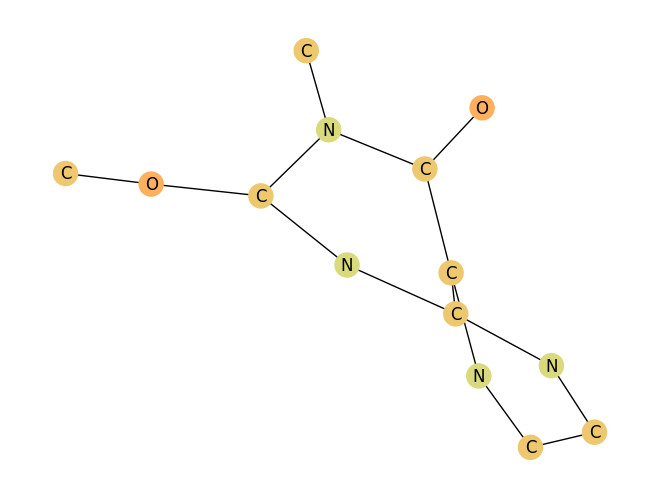

In [218]:
#displaying one sample
plt.clf()
visualize(training_set_T2[5])

In [230]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 80)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["message_calculation_class"] = 'GGNN'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["num_edge_MLP_hidden_layers"] = 2
params["num_heads"] = 8
params["num_layers"] = 4
params["dense_every_num_layers"] = 1
params["film_parameter_MLP_hidden_layers"] = 1


#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(128,activation='relu')(avg)
fc2 = Dense(64,activation='relu')(fc1)

#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc2)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model_2 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_15/StatefulPartitionedCall:0', description="created by layer 'gnn_15'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_15/SegmentMean:0', description="created by layer 'tf.math.segment_mean_15'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_19/Sigmoid:0', description="created by layer 'dense_19'")


In [231]:
#printing summary of the model
model_2.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_48 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_15 (TFOpLam  ()                  0           ['input_48[0][0]']               
 bda)                                                                                             
                                                                                                  
 embedding_15 (Embedding)       (None, 80)           40000       ['input_46[0][0]']        

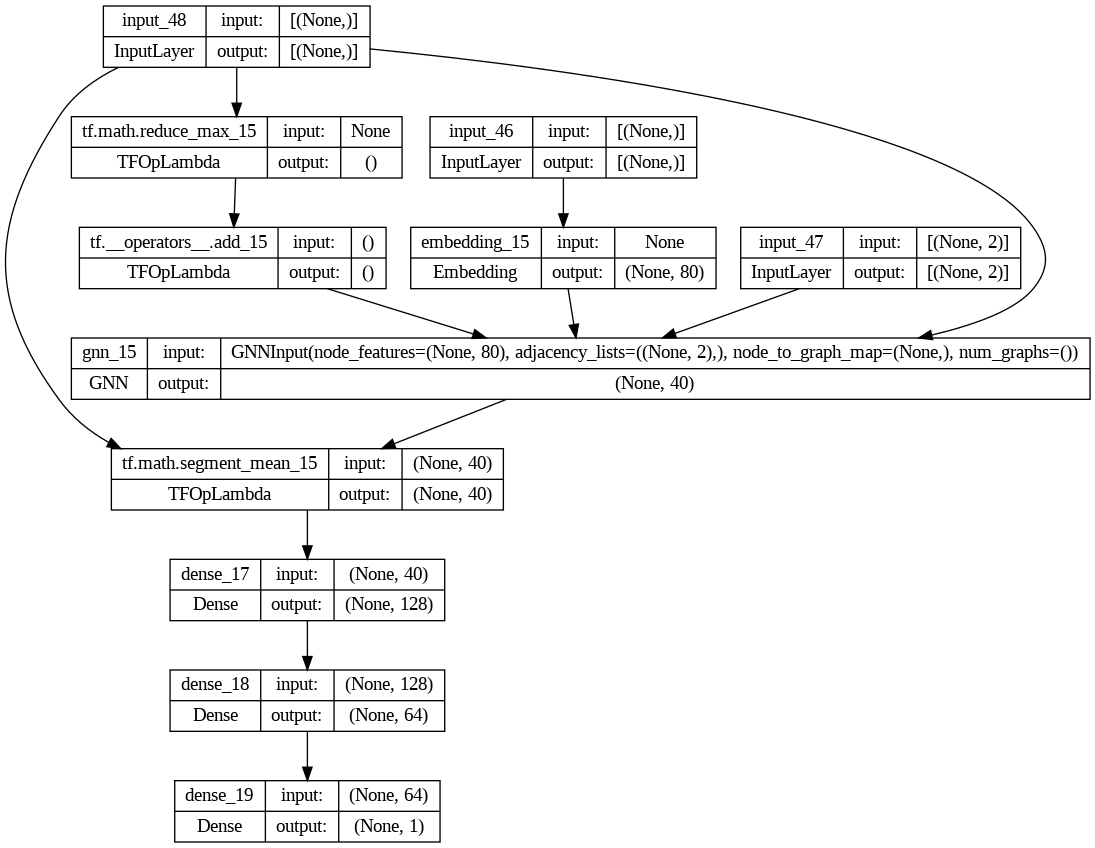

In [232]:
tf.keras.utils.plot_model(model_2, show_shapes=True)

In [233]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model_2.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [234]:
batch_size = 64

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)

#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)


In [235]:
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist_2 = model_2.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
   callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
    verbose=1
)
print(hist_2)

Epoch 1/30
633/633 [==============================] - 25s 25ms/step - loss: 0.6307 - auc: 0.6938 - val_loss: 0.6156 - val_auc: 0.7362
Epoch 2/30
633/633 [==============================] - 14s 22ms/step - loss: 0.5851 - auc: 0.7505 - val_loss: 0.5653 - val_auc: 0.7745
Epoch 3/30
633/633 [==============================] - 14s 23ms/step - loss: 0.5599 - auc: 0.7829 - val_loss: 0.5623 - val_auc: 0.8010
Epoch 4/30
633/633 [==============================] - 14s 23ms/step - loss: 0.5300 - auc: 0.8127 - val_loss: 0.5182 - val_auc: 0.8309
Epoch 5/30
633/633 [==============================] - 14s 22ms/step - loss: 0.5034 - auc: 0.8344 - val_loss: 0.4898 - val_auc: 0.8456
Epoch 6/30
633/633 [==============================] - 14s 21ms/step - loss: 0.4806 - auc: 0.8510 - val_loss: 0.4619 - val_auc: 0.8686
Epoch 7/30
633/633 [==============================] - 14s 22ms/step - loss: 0.4578 - auc: 0.8664 - val_loss: 0.4427 - val_auc: 0.8763
Epoch 8/30
633/633 [==============================] - 14s 22ms

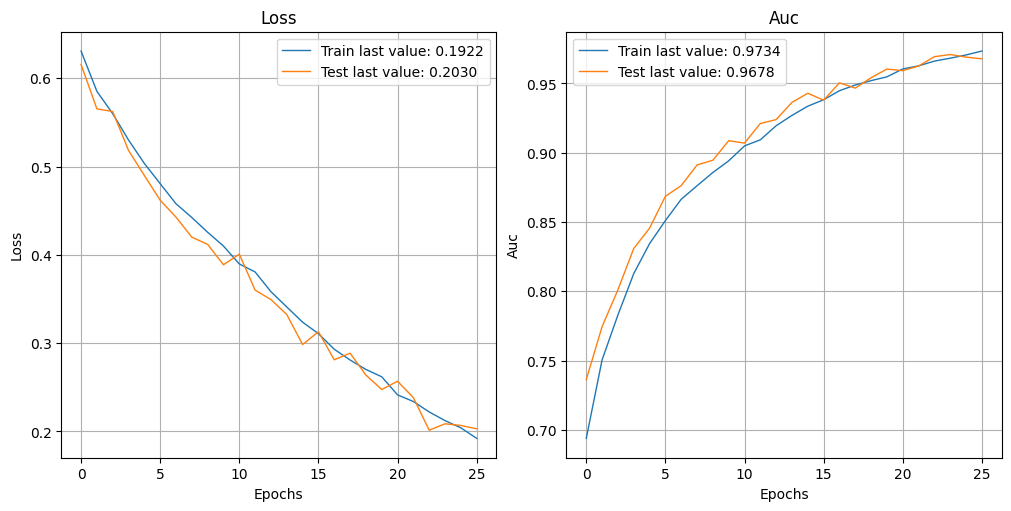

In [240]:
Virt_fun(hist_2)

In [236]:
#make a prediction by using the model
y_pred_2 = model_2.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred_2 = np.reshape(y_pred_2, -1)

386/386 [==============================] - 3s 6ms/step


In [237]:
#make a submission file to upload it on kaggle
submission = pd.DataFrame({'label':y_pred_2})
submission.index.name = 'id'
submission.to_csv('trial_11.csv')

**observation**


**it was as i excepect the GGNN model when take it outside the function the Auc improved and the score in kaggle improved as it's now 0.87575**

# **<a>The End**


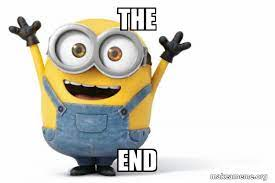

Overall,My trial (6) : GGNN with Upsampling on the training data and the validation data set, significantly assisted me in achieving my highest score on the leaderboard with score of (~0.85). AND I put in a lot of effort in trial 11 with using GGNN with upsampling data class and some preprocessing it give an accuracy in leaderboard **.87575** better accuracy




**Questions & Answers**

**Based on the provided template, describe the format of the input file (sdf file).?**

Answer: A data structure file is used as the input (SDF). It contains information about the chemical composition of a molecule. The positions of individual atoms in a chemical molecule, as well as the connections between them, are stored in SDF files. The symbol $$$$ is used to distinguish between distinct compounds.

The name/title of the substance is mentioned in the header of each sample/molecule. Details on the quantity of Atoms, the version number, and connections, among other things, are included in other sections. The atom block contains information about the compound's ingredients. The bond block describes the bonding structure of the chemical. In this assignment, both of these blocks are used to acquire information about the compound and record it as edges and nodes. In a chemical compound, each node represents an atom.

**What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?**

Answer: This network's input tensors are:

The data in tokenized form contains the chemical molecule's nodes. The nodes of each compound are obtained, tokenized using the tokenizer, then padded using the pad sequence technique. The form of each batch is (batch size * max len nodes). where batch size is the total number of samples in the batch and max len nodes is the maximum length of tokenized nodes after padding.
The form of an edge (sum of all edges,2) is the input tensor that provides information about atom connections. The sum(no. of edges of each sample) of all edges is used to calculate the batch size. Like sample 1 has 21, sample 2 has 20, and sample 3 has 40 edges in a batch of three samples. As a result, the edge tensor's size is reduced (81,2).
The segmented mean input tensor, or node2graph, contains information about segmented ids. (batch size*max len nodes) is the shape of each batch, with batch size equaling the number of samples in the batch and max len nodes equaling the length of tokenized nodes after padding.

**For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?**

Answer: (gnn_out) The shape of the gnn out is defined as (batch size node dimension,hidden layers), where batch size node dimension is the dimension of the input data (node) vector (dimension of tokenized vector for the complete batch). It represents the model's aggregation output for each hidden layer.

Dim of avg : Using the segmented ids, the gnn out's segmented mean is determined. For each sample in the batch size, gnn out returns (tokenized vector dimension, hidden layers). Each sample is allocated a segment id. As a result, by taking the mean of all the output data in the gnn out output, segment mean represents one sample with one integer for each hidden layer. The final output of the average tensor is of the shape (batch size, hidden layer). It's a technique for collecting data for each sample and presenting it as mean data.

**What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?**

Ans: Segment_mean: Computes the average of data with the same segmented ids, or Computes the mean along segments of a tensor.

Reduce_mean: Given parameters, computes the mean of elements across dimensions of a tensor.

dim of pred : The final result (pred) reveals if a chemical compound is effective in killing cancer cells. The shape of pred is (batch size,1). As a result, each sample's final output is a number that represents the probability of each chemical compound's activity.

**What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?**

Answer: For the number of layers, the default template uses the gcn network default option. The default layer, as mentioned in the documentation, is [4]. The default message conveyance technique is rgcn (Graph convolution layers). Using several gcns helps to capture all graph complexity more efficiently, resulting in a better model.